## Gated Recurrent Unit (GRU) Implementation

In [1]:
## Imports

import numpy as np  
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf 
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf # tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, MaxPooling2D,Activation,AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# Loading the Data

In [2]:
## Data Load

CLASS = {'Cars':0, 'Drones': 1, 'People':2}

list_of_file = []   # filename/details
list_of_img = []    # x
list_of_classi = [] # y

for root, dirs, files in os.walk(".", topdown=False):
    for file in files:
        if file.endswith('.csv'):
            tmp = root.strip().split('\\')
            if tmp[-2] in CLASS:
                list_of_classi.append(CLASS[tmp[-2]])
                list_of_file.append(os.path.join('\\'.join(tmp[-3:]),file))
                df = pd.read_csv(os.path.join(root,file), sep=',',header=None)
                list_of_img.append(df.values)

x = np.array(list_of_img)
y = np.array(list_of_classi)
d = np.array(list_of_file)
                
print(len(list_of_file), 'files loaded.')

17485 files loaded.


# Example Person Sample

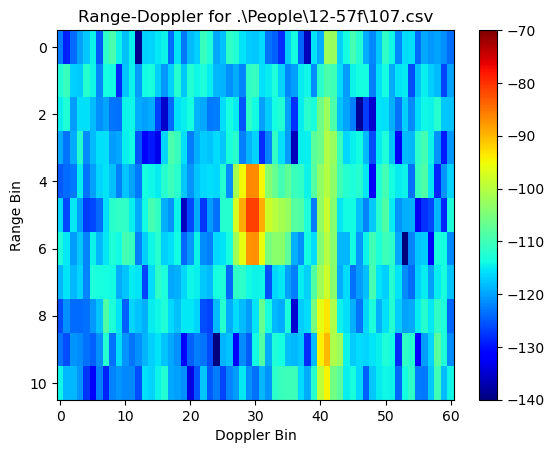

In [3]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[16300], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[16299]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

# Example Drone Sample

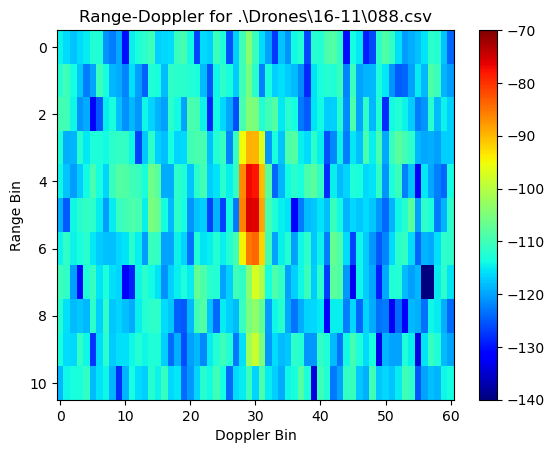

In [4]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[10300], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[10299]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

# Example Car Sample

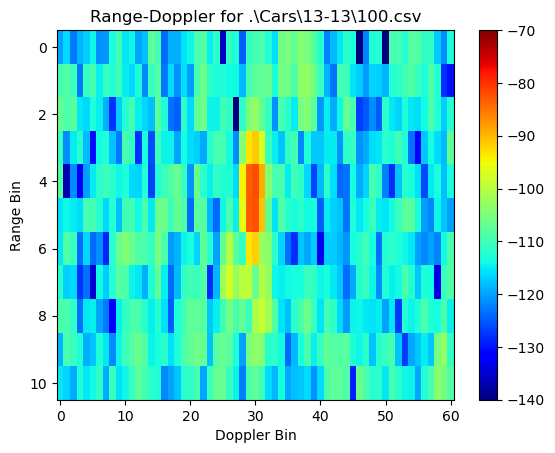

In [5]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[100], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[99]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

# Data Preprocessing

In [6]:
#Preprocessing the Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train_original, x_test_original, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=31, shuffle=True)

x_train_original_shape = x_train_original.shape

# Reshape the data to 2D
x_train_reshaped = x_train_original.reshape(x_train_original.shape[0], -1)

# Create and fit the StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_reshaped)

# Reshape the data back to its original shape
x_train = x_train_scaled.reshape(x_train_original_shape)

# X_test scaling 
x_test_original_shape = x_test_original.shape

# Reshape the data to 2D
x_test_reshaped = x_test_original.reshape(x_test_original.shape[0], -1)

# Create and fit the StandardScaler
scaler = StandardScaler()
x_test_scaled = scaler.fit_transform(x_test_reshaped)

# Reshape the data back to its original shape
x_test = x_test_scaled.reshape(x_test_original_shape)

# Defining the Utility Functions to Plot Accuracies and Losses

In [7]:
##Defining utility functions to plot Accuracies and Losses

def smooth_curve(points,factor = 0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)

  return smoothed_points

def plot_convergence():
  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  plt.plot(smooth_curve(history.history['accuracy']), marker= 'o', label = 'Train Accuracy')
  plt.plot(smooth_curve(history.history['val_accuracy']), marker= 'o', label = 'Validation Accuracy')
  plt.title('Training and Validation Accuracy over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(smooth_curve(history.history['loss']),marker = 'o', label = 'Train Loss')
  plt.plot(smooth_curve(history.history['val_loss']),marker = 'o', label = 'Validation Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()

def test_model_accuracy(model):
  test_loss,test_accuracy = model.evaluate(x_test_gru, y_test_gru)
  print(f"Test Accuracy: {test_accuracy * 100:.4f}%")
  plot_convergence()

# Reshaping the Data for Feeding the GRU (Gated Recurrent Unit)

In [8]:
import numpy as np

def reshape_for_gru(X, y, time_steps):
    # Get the original shape
    samples, height, width = X.shape
    
    # Reshape X to (samples, time_steps, features)
    X_reshaped = X.reshape(samples, time_steps, height * width // time_steps)
    
    # Convert y to one-hot encoded format
    y_onehot = np.eye(np.max(y) + 1)[y]
    
    return X_reshaped, y_onehot

x_train_gru, y_train_gru = reshape_for_gru(x_train, y_train, time_steps=11)
x_test_gru, y_test_gru = reshape_for_gru(x_test, y_test, time_steps=11)

# GRU (Gated Recurrence Unit) Model Building

### One GRU and One Output Layer

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features)),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                24384     
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 24,579
Trainable params: 24,579
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 5s 8ms/step - loss: 0.4643 - accuracy: 0.8095 - val_loss: 0.2956 - val_accuracy: 0.8774
Epoch 2/30
350/350 [==============================] - 2s 7ms/step - loss: 0.2596 - accuracy: 0.8925 - val_loss: 0.2550 - val_accuracy: 0.8931
Epoch 3/30
350/350 [==============================] - 2s 7ms/step - loss: 0.2148 - accuracy: 0.9093 - val_loss: 0.2398 - val_accuracy: 0.9042
Epoch 4/30
350/350 [==============================] - 3s 7ms/step - loss: 0.1814 - accuracy: 0.9265 - val_loss: 0.2342 - val_accuracy: 0.9092
Epoch 5/30
350/350 [==============================] - 3s 7ms/step - loss: 0.1518 - accuracy: 0.9375 - val_loss: 0.2333 - val_accuracy: 0.9103
Epoch 6/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1283 - accuracy: 0.9504 - val_loss: 0.2323 - val_accuracy: 0.9124
Epoch 7/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1070 - accuracy: 0.9596 - val_loss: 0.2305 - val_accuracy: 0.9199
Epoch 

110/110 [==============================] - 0s 3ms/step - loss: 0.5257 - accuracy: 0.9199
Test Accuracy: 91.9931%


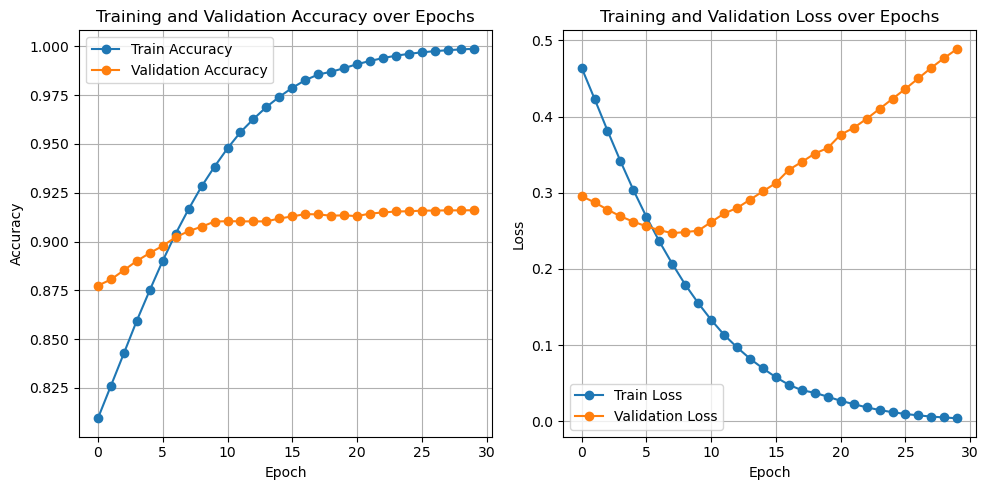

In [24]:
test_model_accuracy(model)

### One GRU, One Dense Layer and One Output Layer

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features)),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                24384     
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 25,475
Trainable params: 25,475
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 5s 8ms/step - loss: 0.4319 - accuracy: 0.8242 - val_loss: 0.2902 - val_accuracy: 0.8824
Epoch 2/30
350/350 [==============================] - 2s 7ms/step - loss: 0.2495 - accuracy: 0.8933 - val_loss: 0.2759 - val_accuracy: 0.8885
Epoch 3/30
350/350 [==============================] - 2s 7ms/step - loss: 0.2076 - accuracy: 0.9137 - val_loss: 0.2349 - val_accuracy: 0.9035
Epoch 4/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1716 - accuracy: 0.9307 - val_loss: 0.2159 - val_accuracy: 0.9132
Epoch 5/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1397 - accuracy: 0.9447 - val_loss: 0.2197 - val_accuracy: 0.9153
Epoch 6/30
350/350 [==============================] - 3s 7ms/step - loss: 0.1178 - accuracy: 0.9537 - val_loss: 0.2290 - val_accuracy: 0.9110
Epoch 7/30
350/350 [==============================] - 3s 8ms/step - loss: 0.0982 - accuracy: 0.9620 - val_loss: 0.2412 - val_accuracy: 0.9160
Epoch 

110/110 [==============================] - 0s 3ms/step - loss: 0.5371 - accuracy: 0.9251
Test Accuracy: 92.5079%


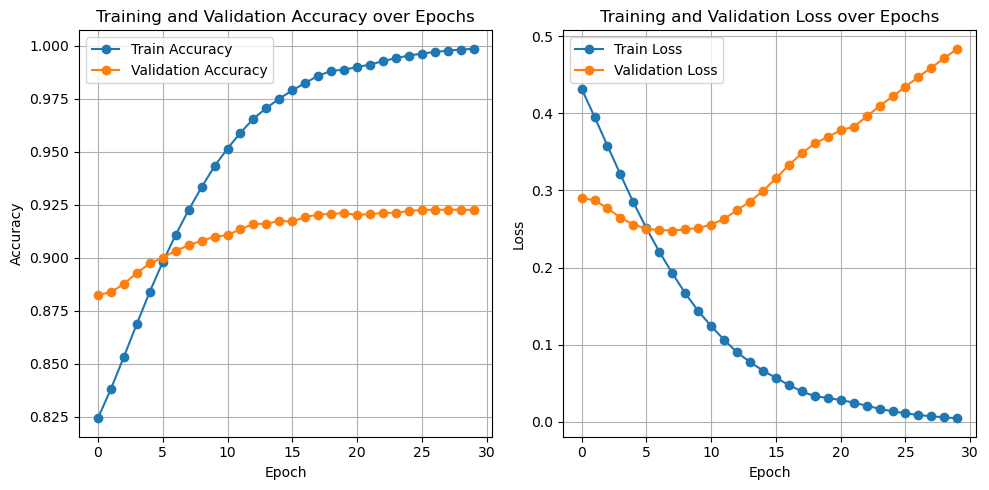

In [28]:
test_model_accuracy(model)

### One GRU, Two Dense Layer and One Output Layer

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features)),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 64)                24384     
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 dense_7 (Dense)             (None, 3)                 51        
                                                                 
Total params: 25,747
Trainable params: 25,747
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 5s 9ms/step - loss: 0.4599 - accuracy: 0.8182 - val_loss: 0.2785 - val_accuracy: 0.8888
Epoch 2/30
350/350 [==============================] - 3s 7ms/step - loss: 0.2568 - accuracy: 0.8932 - val_loss: 0.2562 - val_accuracy: 0.8949
Epoch 3/30
350/350 [==============================] - 3s 8ms/step - loss: 0.2116 - accuracy: 0.9104 - val_loss: 0.2323 - val_accuracy: 0.9064
Epoch 4/30
350/350 [==============================] - 3s 7ms/step - loss: 0.1756 - accuracy: 0.9308 - val_loss: 0.2208 - val_accuracy: 0.9117
Epoch 5/30
350/350 [==============================] - 3s 7ms/step - loss: 0.1453 - accuracy: 0.9430 - val_loss: 0.2155 - val_accuracy: 0.9178
Epoch 6/30
350/350 [==============================] - 3s 7ms/step - loss: 0.1223 - accuracy: 0.9518 - val_loss: 0.2346 - val_accuracy: 0.9149
Epoch 7/30
350/350 [==============================] - 3s 7ms/step - loss: 0.0995 - accuracy: 0.9621 - val_loss: 0.2366 - val_accuracy: 0.9192
Epoch 

110/110 [==============================] - 0s 3ms/step - loss: 0.5964 - accuracy: 0.9196
Test Accuracy: 91.9645%


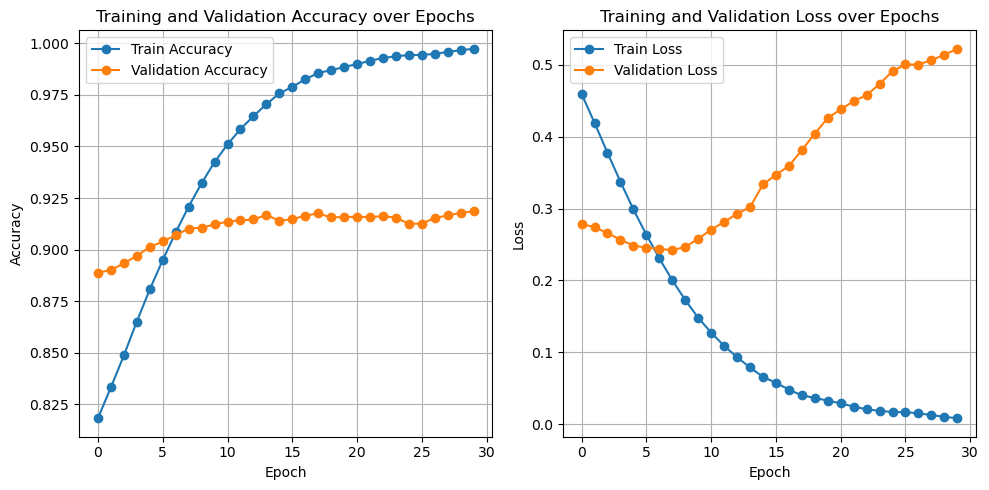

In [31]:
test_model_accuracy(model)

### One GRU, Three Dense Layer and One Output Layer

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features)),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 64)                24384     
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dense_9 (Dense)             (None, 16)                272       
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 3)                 51        
                                                                 
Total params: 26,019
Trainable params: 26,019
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 5s 9ms/step - loss: 0.4974 - accuracy: 0.7994 - val_loss: 0.3034 - val_accuracy: 0.8767
Epoch 2/30
350/350 [==============================] - 3s 8ms/step - loss: 0.2698 - accuracy: 0.8887 - val_loss: 0.2898 - val_accuracy: 0.8863
Epoch 3/30
350/350 [==============================] - 2s 7ms/step - loss: 0.2327 - accuracy: 0.9049 - val_loss: 0.2496 - val_accuracy: 0.8989
Epoch 4/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1930 - accuracy: 0.9211 - val_loss: 0.2473 - val_accuracy: 0.9006
Epoch 5/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1568 - accuracy: 0.9385 - val_loss: 0.2305 - val_accuracy: 0.9160
Epoch 6/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1331 - accuracy: 0.9473 - val_loss: 0.2229 - val_accuracy: 0.9182
Epoch 7/30
350/350 [==============================] - 2s 7ms/step - loss: 0.1098 - accuracy: 0.9556 - val_loss: 0.2269 - val_accuracy: 0.9189
Epoch 

110/110 [==============================] - 0s 3ms/step - loss: 0.5476 - accuracy: 0.9154
Test Accuracy: 91.5356%


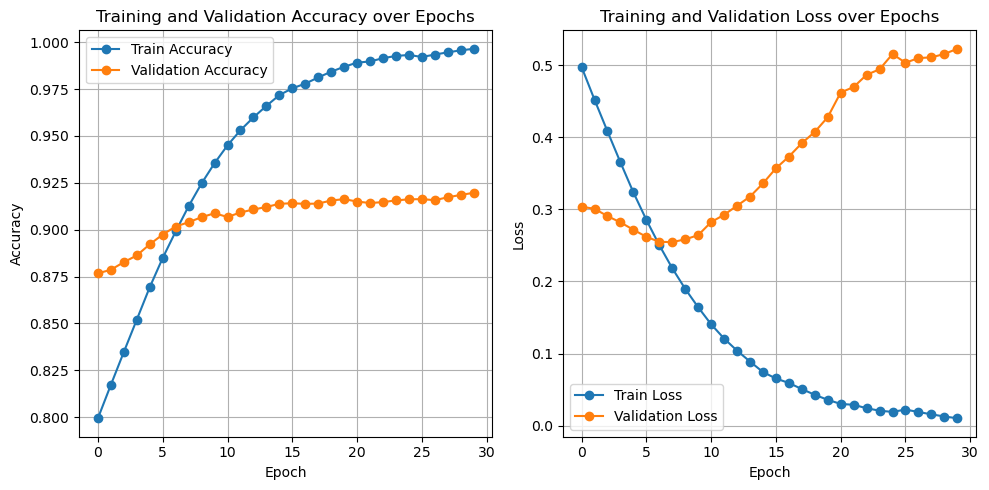

In [34]:
test_model_accuracy(model)

### Two GRU One Output Layer

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(32),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 11, 64)            24384     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 33,891
Trainable params: 33,891
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 9s 14ms/step - loss: 0.4224 - accuracy: 0.8262 - val_loss: 0.2834 - val_accuracy: 0.8874
Epoch 2/30
350/350 [==============================] - 4s 12ms/step - loss: 0.2444 - accuracy: 0.8973 - val_loss: 0.2667 - val_accuracy: 0.8842
Epoch 3/30
350/350 [==============================] - 5s 13ms/step - loss: 0.2001 - accuracy: 0.9160 - val_loss: 0.2220 - val_accuracy: 0.9085
Epoch 4/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1680 - accuracy: 0.9305 - val_loss: 0.2129 - val_accuracy: 0.9167
Epoch 5/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1444 - accuracy: 0.9420 - val_loss: 0.2177 - val_accuracy: 0.9192
Epoch 6/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1178 - accuracy: 0.9513 - val_loss: 0.2167 - val_accuracy: 0.9217
Epoch 7/30
350/350 [==============================] - 5s 13ms/step - loss: 0.1050 - accuracy: 0.9603 - val_loss: 0.2307 - val_accuracy: 0.9264

110/110 [==============================] - 1s 5ms/step - loss: 0.5719 - accuracy: 0.9214
Test Accuracy: 92.1361%


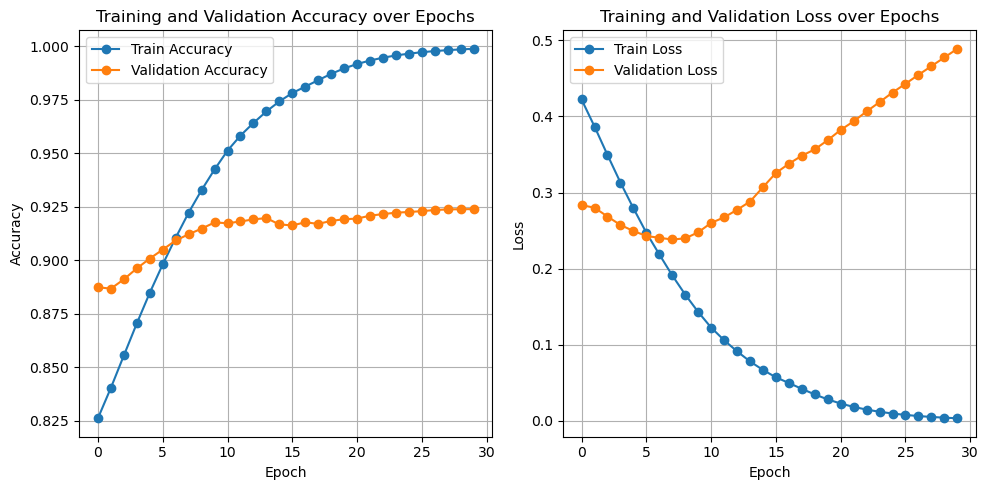

In [15]:
test_model_accuracy(model)

### Two GRU, One Dense Layer and One Output Layer

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 11, 64)            24384     
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 3)                 51        
                                                                 
Total params: 34,371
Trainable params: 34,371
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 9s 16ms/step - loss: 0.4452 - accuracy: 0.8199 - val_loss: 0.2884 - val_accuracy: 0.8881
Epoch 2/30
350/350 [==============================] - 4s 12ms/step - loss: 0.2505 - accuracy: 0.8965 - val_loss: 0.2581 - val_accuracy: 0.8978
Epoch 3/30
350/350 [==============================] - 4s 12ms/step - loss: 0.2047 - accuracy: 0.9157 - val_loss: 0.2272 - val_accuracy: 0.9121
Epoch 4/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1675 - accuracy: 0.9340 - val_loss: 0.2464 - val_accuracy: 0.9071
Epoch 5/30
350/350 [==============================] - 5s 13ms/step - loss: 0.1420 - accuracy: 0.9427 - val_loss: 0.2246 - val_accuracy: 0.9139
Epoch 6/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1116 - accuracy: 0.9575 - val_loss: 0.2116 - val_accuracy: 0.9249
Epoch 7/30
350/350 [==============================] - 4s 12ms/step - loss: 0.0887 - accuracy: 0.9688 - val_loss: 0.2202 - val_accuracy: 0.9203

110/110 [==============================] - 0s 4ms/step - loss: 0.4719 - accuracy: 0.9279
Test Accuracy: 92.7938%


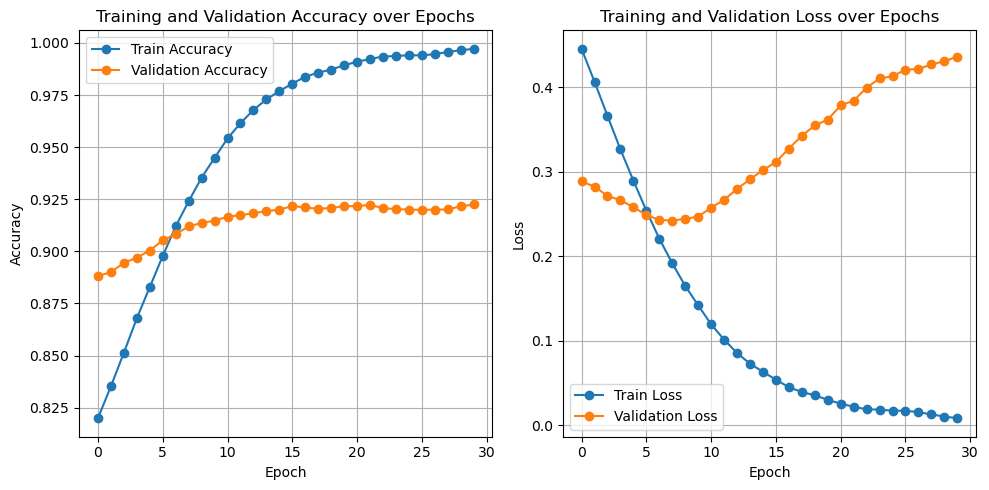

In [18]:
test_model_accuracy(model)

### Two GRU, Two Dense Layer and One Output Layer (Selected for Next Step)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 11, 64)            24384     
                                                                 
 gru_7 (GRU)                 (None, 32)                9408      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dense_9 (Dense)             (None, 3)                 51        
                                                                 
Total params: 34,643
Trainable params: 34,643
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 9s 15ms/step - loss: 0.4215 - accuracy: 0.8396 - val_loss: 0.3325 - val_accuracy: 0.8728
Epoch 2/30
350/350 [==============================] - 4s 12ms/step - loss: 0.2503 - accuracy: 0.8979 - val_loss: 0.2681 - val_accuracy: 0.8914
Epoch 3/30
350/350 [==============================] - 4s 12ms/step - loss: 0.2098 - accuracy: 0.9118 - val_loss: 0.2553 - val_accuracy: 0.8953
Epoch 4/30
350/350 [==============================] - 5s 14ms/step - loss: 0.1752 - accuracy: 0.9273 - val_loss: 0.2209 - val_accuracy: 0.9142
Epoch 5/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1421 - accuracy: 0.9421 - val_loss: 0.2200 - val_accuracy: 0.9242
Epoch 6/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1172 - accuracy: 0.9519 - val_loss: 0.2263 - val_accuracy: 0.9210
Epoch 7/30
350/350 [==============================] - 4s 12ms/step - loss: 0.0998 - accuracy: 0.9602 - val_loss: 0.2374 - val_accuracy: 0.9239

110/110 [==============================] - 0s 4ms/step - loss: 0.4878 - accuracy: 0.9282
Test Accuracy: 92.8224%


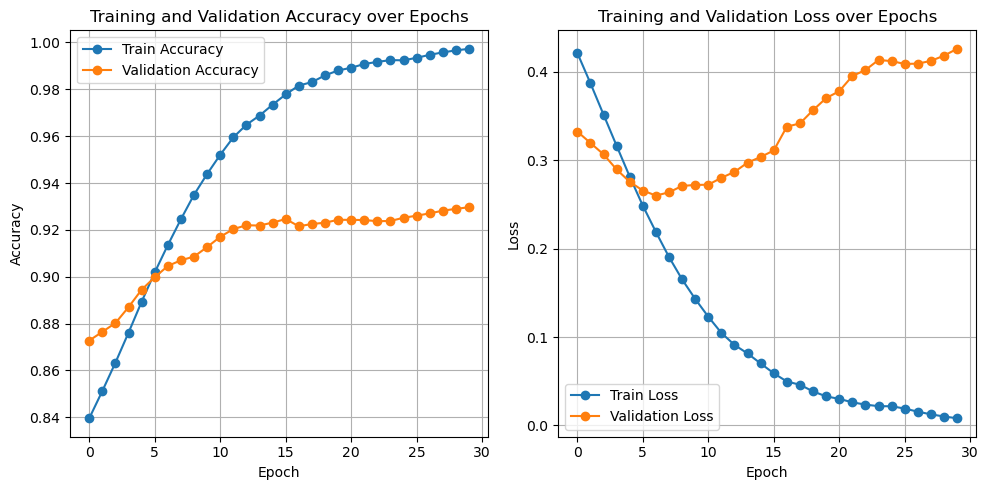

In [21]:
test_model_accuracy(model)

### Two GRU, Three Dense Layer and One Output Layer

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 11, 64)            24384     
                                                                 
 gru_9 (GRU)                 (None, 32)                9408      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 16)                272       
                                                                 
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 dense_13 (Dense)            (None, 3)                 51        
                                                                 
Total params: 34,915
Trainable params: 34,915
Non-trai

In [23]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 9s 15ms/step - loss: 0.4613 - accuracy: 0.8140 - val_loss: 0.2856 - val_accuracy: 0.8842
Epoch 2/30
350/350 [==============================] - 4s 12ms/step - loss: 0.2533 - accuracy: 0.8929 - val_loss: 0.2413 - val_accuracy: 0.9039
Epoch 3/30
350/350 [==============================] - 4s 12ms/step - loss: 0.2137 - accuracy: 0.9099 - val_loss: 0.2224 - val_accuracy: 0.9153
Epoch 4/30
350/350 [==============================] - 5s 14ms/step - loss: 0.1783 - accuracy: 0.9270 - val_loss: 0.2164 - val_accuracy: 0.9199
Epoch 5/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1528 - accuracy: 0.9385 - val_loss: 0.2152 - val_accuracy: 0.9207
Epoch 6/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1301 - accuracy: 0.9502 - val_loss: 0.2365 - val_accuracy: 0.9146
Epoch 7/30
350/350 [==============================] - 4s 13ms/step - loss: 0.1156 - accuracy: 0.9545 - val_loss: 0.2174 - val_accuracy: 0.9239

110/110 [==============================] - 1s 4ms/step - loss: 0.5438 - accuracy: 0.9148
Test Accuracy: 91.4784%


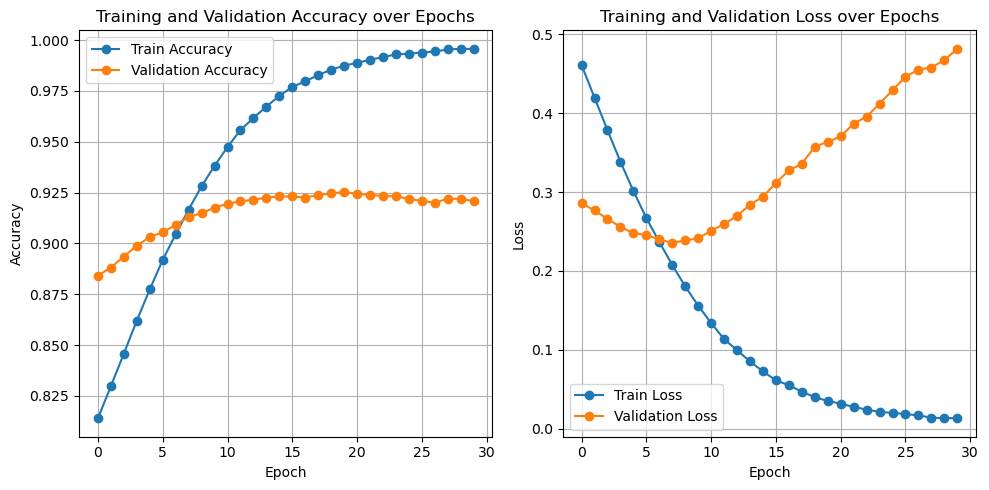

In [24]:
test_model_accuracy(model)

### Two GRU, Four Dense Layer and One Output Layer

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 11, 64)            24384     
                                                                 
 gru_11 (GRU)                (None, 32)                9408      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 16)                272       
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 16)                272       
                                                                 
 dense_18 (Dense)            (None, 3)                

In [26]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 9s 15ms/step - loss: 0.4911 - accuracy: 0.8086 - val_loss: 0.2875 - val_accuracy: 0.8835
Epoch 2/30
350/350 [==============================] - 4s 12ms/step - loss: 0.2649 - accuracy: 0.8923 - val_loss: 0.2653 - val_accuracy: 0.8971
Epoch 3/30
350/350 [==============================] - 5s 13ms/step - loss: 0.2118 - accuracy: 0.9137 - val_loss: 0.2529 - val_accuracy: 0.9003
Epoch 4/30
350/350 [==============================] - 5s 13ms/step - loss: 0.1817 - accuracy: 0.9265 - val_loss: 0.2467 - val_accuracy: 0.9089
Epoch 5/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1507 - accuracy: 0.9399 - val_loss: 0.2281 - val_accuracy: 0.9085
Epoch 6/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1273 - accuracy: 0.9506 - val_loss: 0.2167 - val_accuracy: 0.9171
Epoch 7/30
350/350 [==============================] - 5s 14ms/step - loss: 0.1067 - accuracy: 0.9578 - val_loss: 0.2244 - val_accuracy: 0.9096

110/110 [==============================] - 1s 5ms/step - loss: 0.4861 - accuracy: 0.9271
Test Accuracy: 92.7080%


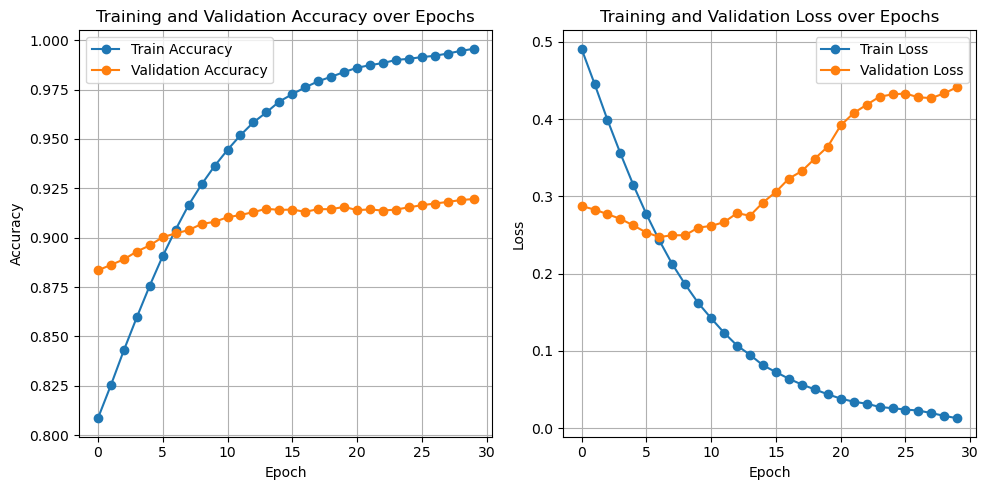

In [27]:
test_model_accuracy(model)

### Two GRU, Five Dense Layer and One Output Layer

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 11, 64)            24384     
                                                                 
 gru_13 (GRU)                (None, 32)                9408      
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 16)                272       
                                                                 
 dense_21 (Dense)            (None, 16)                272       
                                                                 
 dense_22 (Dense)            (None, 16)                272       
                                                                 
 dense_23 (Dense)            (None, 16)               

In [29]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 9s 15ms/step - loss: 0.4806 - accuracy: 0.8068 - val_loss: 0.2943 - val_accuracy: 0.8853
Epoch 2/30
350/350 [==============================] - 4s 13ms/step - loss: 0.2534 - accuracy: 0.8959 - val_loss: 0.2463 - val_accuracy: 0.8996
Epoch 3/30
350/350 [==============================] - 5s 14ms/step - loss: 0.2118 - accuracy: 0.9106 - val_loss: 0.2385 - val_accuracy: 0.8960
Epoch 4/30
350/350 [==============================] - 5s 13ms/step - loss: 0.1736 - accuracy: 0.9257 - val_loss: 0.2349 - val_accuracy: 0.9035
Epoch 5/30
350/350 [==============================] - 4s 13ms/step - loss: 0.1510 - accuracy: 0.9392 - val_loss: 0.2341 - val_accuracy: 0.9182
Epoch 6/30
350/350 [==============================] - 5s 13ms/step - loss: 0.1307 - accuracy: 0.9481 - val_loss: 0.2256 - val_accuracy: 0.9232
Epoch 7/30
350/350 [==============================] - 5s 14ms/step - loss: 0.1075 - accuracy: 0.9582 - val_loss: 0.2146 - val_accuracy: 0.9260

110/110 [==============================] - 1s 5ms/step - loss: 0.4599 - accuracy: 0.9251
Test Accuracy: 92.5079%


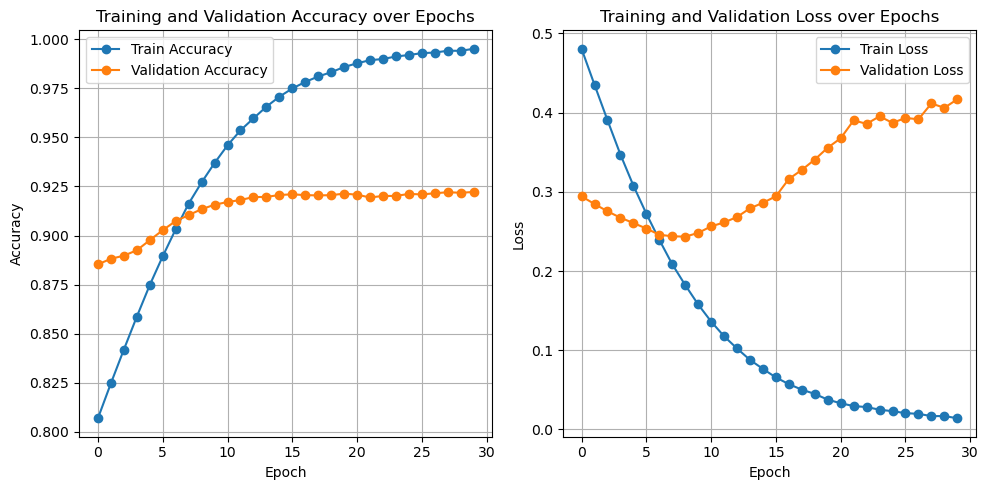

In [30]:
test_model_accuracy(model)

### Three GRUs and One Output Layer

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(32,return_sequences=True),
    GRU(16),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 11, 64)            24384     
                                                                 
 gru_15 (GRU)                (None, 11, 32)            9408      
                                                                 
 gru_16 (GRU)                (None, 16)                2400      
                                                                 
 dense_25 (Dense)            (None, 3)                 51        
                                                                 
Total params: 36,243
Trainable params: 36,243
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 13s 22ms/step - loss: 0.4107 - accuracy: 0.8351 - val_loss: 0.2674 - val_accuracy: 0.8924
Epoch 2/30
350/350 [==============================] - 6s 17ms/step - loss: 0.2387 - accuracy: 0.9031 - val_loss: 0.2314 - val_accuracy: 0.9089
Epoch 3/30
350/350 [==============================] - 6s 17ms/step - loss: 0.1913 - accuracy: 0.9239 - val_loss: 0.2383 - val_accuracy: 0.8967
Epoch 4/30
350/350 [==============================] - 6s 18ms/step - loss: 0.1587 - accuracy: 0.9364 - val_loss: 0.2053 - val_accuracy: 0.9224
Epoch 5/30
350/350 [==============================] - 6s 17ms/step - loss: 0.1261 - accuracy: 0.9534 - val_loss: 0.2192 - val_accuracy: 0.9185
Epoch 6/30
350/350 [==============================] - 7s 19ms/step - loss: 0.1053 - accuracy: 0.9618 - val_loss: 0.2114 - val_accuracy: 0.9246
Epoch 7/30
350/350 [==============================] - 6s 18ms/step - loss: 0.0895 - accuracy: 0.9676 - val_loss: 0.2234 - val_accuracy: 0.928

110/110 [==============================] - 1s 6ms/step - loss: 0.4044 - accuracy: 0.9194
Test Accuracy: 91.9359%


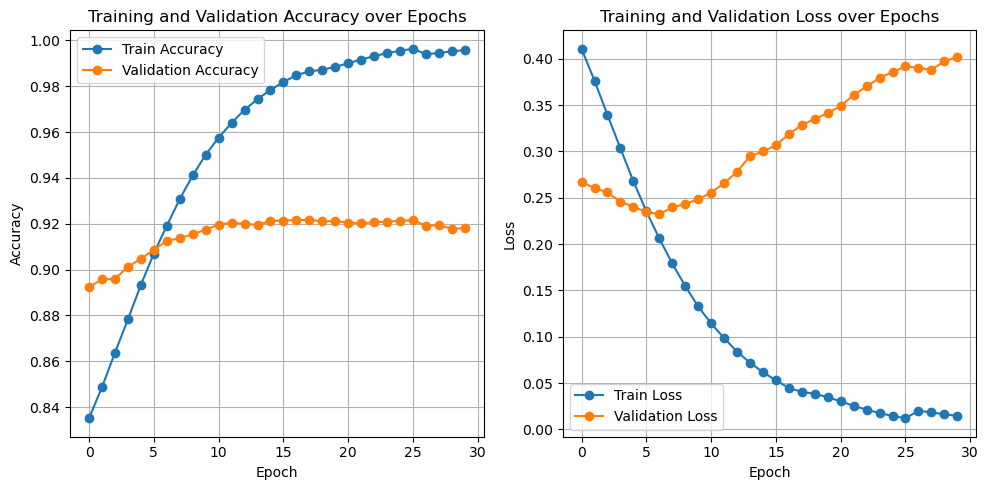

In [33]:
test_model_accuracy(model)

### Three GRUs, One Dense Layer and One Output Layer

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(32,return_sequences=True),
    GRU(16),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_17 (GRU)                (None, 11, 64)            24384     
                                                                 
 gru_18 (GRU)                (None, 11, 32)            9408      
                                                                 
 gru_19 (GRU)                (None, 16)                2400      
                                                                 
 dense_26 (Dense)            (None, 16)                272       
                                                                 
 dense_27 (Dense)            (None, 3)                 51        
                                                                 
Total params: 36,515
Trainable params: 36,515
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 13s 21ms/step - loss: 0.4344 - accuracy: 0.8338 - val_loss: 0.2923 - val_accuracy: 0.8835
Epoch 2/30
350/350 [==============================] - 6s 18ms/step - loss: 0.2523 - accuracy: 0.8992 - val_loss: 0.2529 - val_accuracy: 0.8964
Epoch 3/30
350/350 [==============================] - 6s 17ms/step - loss: 0.2130 - accuracy: 0.9128 - val_loss: 0.2399 - val_accuracy: 0.9074
Epoch 4/30
350/350 [==============================] - 6s 18ms/step - loss: 0.1705 - accuracy: 0.9295 - val_loss: 0.2330 - val_accuracy: 0.9110
Epoch 5/30
350/350 [==============================] - 6s 17ms/step - loss: 0.1440 - accuracy: 0.9421 - val_loss: 0.2188 - val_accuracy: 0.9167
Epoch 6/30
350/350 [==============================] - 6s 18ms/step - loss: 0.1221 - accuracy: 0.9514 - val_loss: 0.2370 - val_accuracy: 0.9157
Epoch 7/30
350/350 [==============================] - 7s 20ms/step - loss: 0.1014 - accuracy: 0.9609 - val_loss: 0.2300 - val_accuracy: 0.917

110/110 [==============================] - 1s 6ms/step - loss: 0.4126 - accuracy: 0.9259
Test Accuracy: 92.5937%


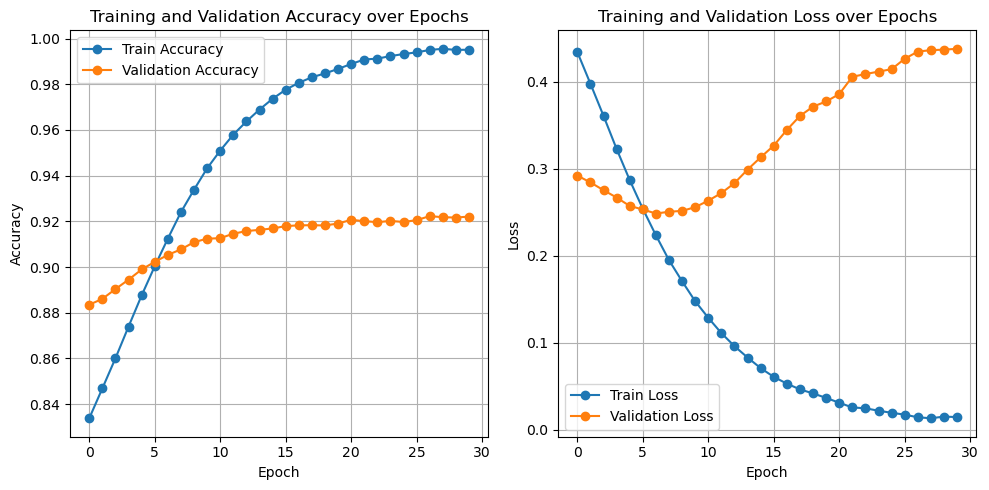

In [36]:
test_model_accuracy(model)

### Two GRU, Two Dense Layer and One Output Layer (Selected for Next Step)
#### Testing with Batch Size 64

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 11, 64)            24384     
                                                                 
 gru_25 (GRU)                (None, 32)                9408      
                                                                 
 dense_34 (Dense)            (None, 16)                528       
                                                                 
 dense_35 (Dense)            (None, 16)                272       
                                                                 
 dense_36 (Dense)            (None, 3)                 51        
                                                                 
Total params: 34,643
Trainable params: 34,643
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 7s 18ms/step - loss: 0.5417 - accuracy: 0.7749 - val_loss: 0.3130 - val_accuracy: 0.8767
Epoch 2/30
175/175 [==============================] - 2s 14ms/step - loss: 0.2740 - accuracy: 0.8898 - val_loss: 0.2537 - val_accuracy: 0.8928
Epoch 3/30
175/175 [==============================] - 3s 15ms/step - loss: 0.2218 - accuracy: 0.9091 - val_loss: 0.2301 - val_accuracy: 0.9056
Epoch 4/30
175/175 [==============================] - 2s 14ms/step - loss: 0.1855 - accuracy: 0.9233 - val_loss: 0.2247 - val_accuracy: 0.9092
Epoch 5/30
175/175 [==============================] - 2s 13ms/step - loss: 0.1539 - accuracy: 0.9362 - val_loss: 0.2110 - val_accuracy: 0.9199
Epoch 6/30
175/175 [==============================] - 2s 14ms/step - loss: 0.1373 - accuracy: 0.9441 - val_loss: 0.2154 - val_accuracy: 0.9203
Epoch 7/30
175/175 [==============================] - 3s 15ms/step - loss: 0.1094 - accuracy: 0.9563 - val_loss: 0.2002 - val_accuracy: 0.9289

110/110 [==============================] - 0s 4ms/step - loss: 0.5341 - accuracy: 0.9282
Test Accuracy: 92.8224%


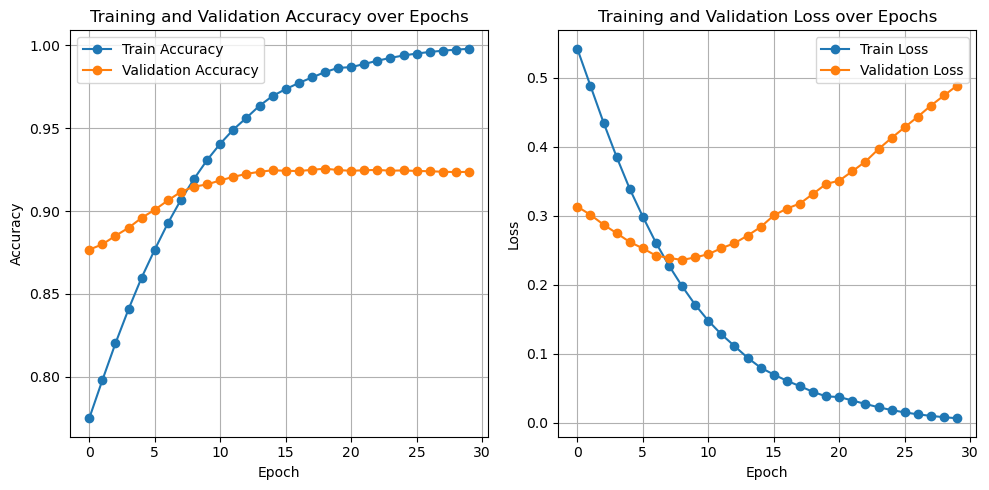

In [44]:
test_model_accuracy(model)

### Two GRU, Two Dense Layer and One Output Layer
#### Testing with Batch Size 16

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_26 (GRU)                (None, 11, 64)            24384     
                                                                 
 gru_27 (GRU)                (None, 32)                9408      
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dense_38 (Dense)            (None, 16)                272       
                                                                 
 dense_39 (Dense)            (None, 3)                 51        
                                                                 
Total params: 34,643
Trainable params: 34,643
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=16)

Epoch 1/30
700/700 [==============================] - 13s 13ms/step - loss: 0.4358 - accuracy: 0.8109 - val_loss: 0.2892 - val_accuracy: 0.8799
Epoch 2/30
700/700 [==============================] - 8s 12ms/step - loss: 0.2423 - accuracy: 0.8996 - val_loss: 0.2414 - val_accuracy: 0.9031
Epoch 3/30
700/700 [==============================] - 8s 12ms/step - loss: 0.1934 - accuracy: 0.9205 - val_loss: 0.2234 - val_accuracy: 0.9117
Epoch 4/30
700/700 [==============================] - 8s 12ms/step - loss: 0.1613 - accuracy: 0.9346 - val_loss: 0.2211 - val_accuracy: 0.9153
Epoch 5/30
700/700 [==============================] - 9s 12ms/step - loss: 0.1299 - accuracy: 0.9490 - val_loss: 0.2187 - val_accuracy: 0.9242
Epoch 6/30
700/700 [==============================] - 9s 13ms/step - loss: 0.1101 - accuracy: 0.9574 - val_loss: 0.2270 - val_accuracy: 0.9214
Epoch 7/30
700/700 [==============================] - 9s 13ms/step - loss: 0.0819 - accuracy: 0.9686 - val_loss: 0.2382 - val_accuracy: 0.921

110/110 [==============================] - 1s 4ms/step - loss: 0.5498 - accuracy: 0.9165
Test Accuracy: 91.6500%


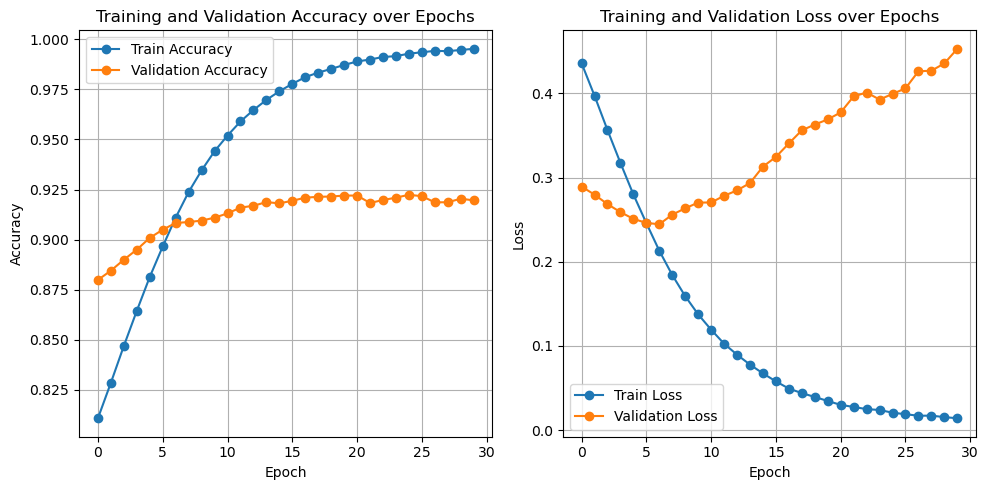

In [47]:
test_model_accuracy(model)

### Two GRU, Two Dense Layer and One Output Layer (Selected for the Next Step)
#### Increasing the Kernel Size GRUs (128-64)

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(64),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_28 (GRU)                (None, 11, 128)           73344     
                                                                 
 gru_29 (GRU)                (None, 64)                37248     
                                                                 
 dense_40 (Dense)            (None, 16)                1040      
                                                                 
 dense_41 (Dense)            (None, 16)                272       
                                                                 
 dense_42 (Dense)            (None, 3)                 51        
                                                                 
Total params: 111,955
Trainable params: 111,955
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 23ms/step - loss: 0.4397 - accuracy: 0.8180 - val_loss: 0.2936 - val_accuracy: 0.8778
Epoch 2/30
175/175 [==============================] - 3s 16ms/step - loss: 0.2478 - accuracy: 0.8995 - val_loss: 0.2319 - val_accuracy: 0.9074
Epoch 3/30
175/175 [==============================] - 3s 16ms/step - loss: 0.1915 - accuracy: 0.9196 - val_loss: 0.2145 - val_accuracy: 0.9153
Epoch 4/30
175/175 [==============================] - 3s 17ms/step - loss: 0.1573 - accuracy: 0.9354 - val_loss: 0.2086 - val_accuracy: 0.9214
Epoch 5/30
175/175 [==============================] - 3s 16ms/step - loss: 0.1289 - accuracy: 0.9486 - val_loss: 0.2146 - val_accuracy: 0.9207
Epoch 6/30
175/175 [==============================] - 3s 16ms/step - loss: 0.1096 - accuracy: 0.9550 - val_loss: 0.2020 - val_accuracy: 0.9264
Epoch 7/30
175/175 [==============================] - 3s 16ms/step - loss: 0.0881 - accuracy: 0.9655 - val_loss: 0.2065 - val_accuracy: 0.9289

110/110 [==============================] - 1s 5ms/step - loss: 0.4499 - accuracy: 0.9377
Test Accuracy: 93.7661%


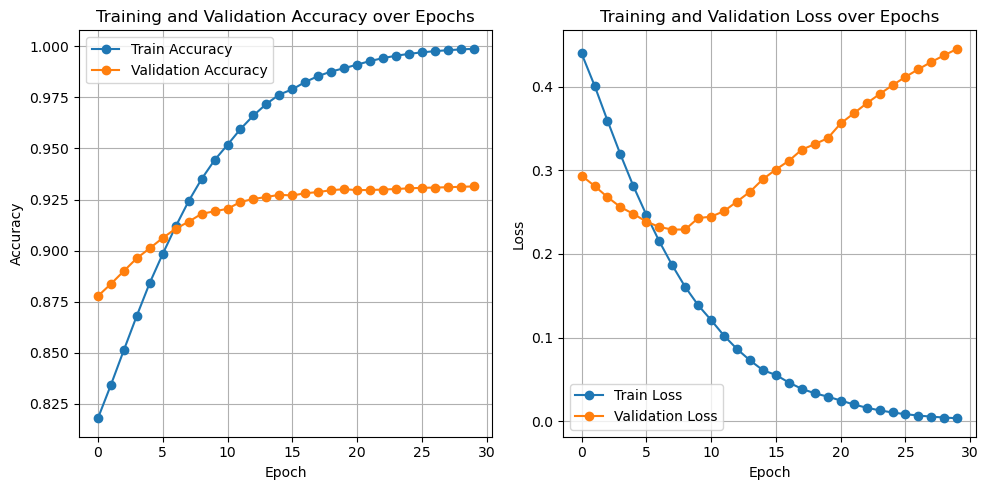

In [50]:
test_model_accuracy(model)

### Two GRU, Two Dense Layer and One Output Layer
#### Increasing the Kernel Size GRUs (256-128)

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(256, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(128),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_30 (GRU)                (None, 11, 256)           244992    
                                                                 
 gru_31 (GRU)                (None, 128)               148224    
                                                                 
 dense_43 (Dense)            (None, 16)                2064      
                                                                 
 dense_44 (Dense)            (None, 16)                272       
                                                                 
 dense_45 (Dense)            (None, 3)                 51        
                                                                 
Total params: 395,603
Trainable params: 395,603
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 9s 31ms/step - loss: 0.3779 - accuracy: 0.8513 - val_loss: 0.2539 - val_accuracy: 0.8989
Epoch 2/30
175/175 [==============================] - 4s 25ms/step - loss: 0.2190 - accuracy: 0.9112 - val_loss: 0.2100 - val_accuracy: 0.9167
Epoch 3/30
175/175 [==============================] - 4s 24ms/step - loss: 0.1744 - accuracy: 0.9285 - val_loss: 0.1908 - val_accuracy: 0.9303
Epoch 4/30
175/175 [==============================] - 4s 24ms/step - loss: 0.1387 - accuracy: 0.9480 - val_loss: 0.1979 - val_accuracy: 0.9325
Epoch 5/30
175/175 [==============================] - 5s 26ms/step - loss: 0.1152 - accuracy: 0.9567 - val_loss: 0.1897 - val_accuracy: 0.9375
Epoch 6/30
175/175 [==============================] - 4s 25ms/step - loss: 0.0947 - accuracy: 0.9659 - val_loss: 0.2076 - val_accuracy: 0.9332
Epoch 7/30
175/175 [==============================] - 4s 24ms/step - loss: 0.0749 - accuracy: 0.9722 - val_loss: 0.2269 - val_accuracy: 0.9335

110/110 [==============================] - 1s 7ms/step - loss: 0.4132 - accuracy: 0.9365
Test Accuracy: 93.6517%


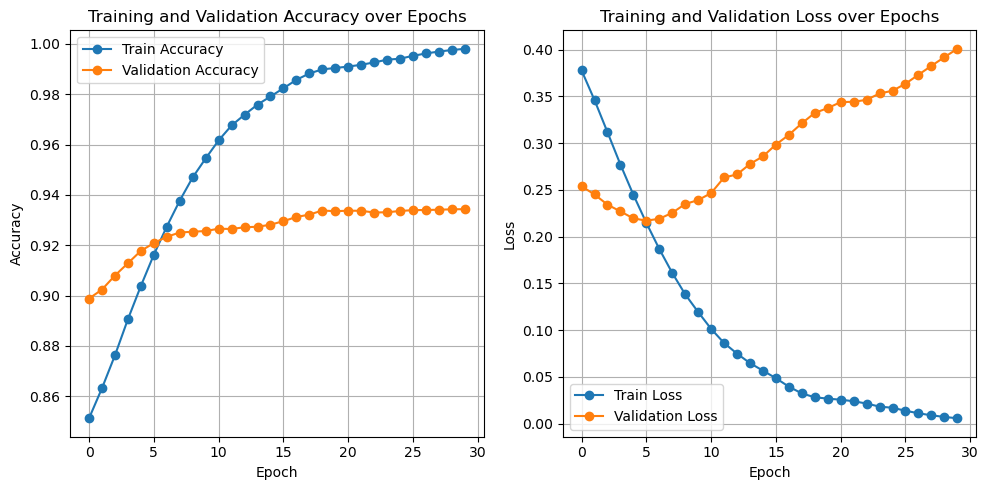

In [53]:
test_model_accuracy(model)

### Two GRU, Two Dense Layer and One Output Layer
#### Increasing the Kernel Size GRUs (512-256)

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(512, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(256),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_32 (GRU)                (None, 11, 512)           883200    
                                                                 
 gru_33 (GRU)                (None, 256)               591360    
                                                                 
 dense_46 (Dense)            (None, 16)                4112      
                                                                 
 dense_47 (Dense)            (None, 16)                272       
                                                                 
 dense_48 (Dense)            (None, 3)                 51        
                                                                 
Total params: 1,478,995
Trainable params: 1,478,995
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 14s 59ms/step - loss: 0.3591 - accuracy: 0.8607 - val_loss: 0.2468 - val_accuracy: 0.8985
Epoch 2/30
175/175 [==============================] - 10s 57ms/step - loss: 0.2075 - accuracy: 0.9164 - val_loss: 0.2088 - val_accuracy: 0.9242
Epoch 3/30
175/175 [==============================] - 10s 54ms/step - loss: 0.1587 - accuracy: 0.9373 - val_loss: 0.2093 - val_accuracy: 0.9292
Epoch 4/30
175/175 [==============================] - 10s 60ms/step - loss: 0.1343 - accuracy: 0.9485 - val_loss: 0.2264 - val_accuracy: 0.9224
Epoch 5/30
175/175 [==============================] - 11s 60ms/step - loss: 0.1021 - accuracy: 0.9641 - val_loss: 0.1893 - val_accuracy: 0.9382
Epoch 6/30
175/175 [==============================] - 10s 58ms/step - loss: 0.0784 - accuracy: 0.9710 - val_loss: 0.2139 - val_accuracy: 0.9310
Epoch 7/30
175/175 [==============================] - 11s 61ms/step - loss: 0.0728 - accuracy: 0.9736 - val_loss: 0.2174 - val_accuracy:

110/110 [==============================] - 1s 11ms/step - loss: 0.3156 - accuracy: 0.9371
Test Accuracy: 93.7089%


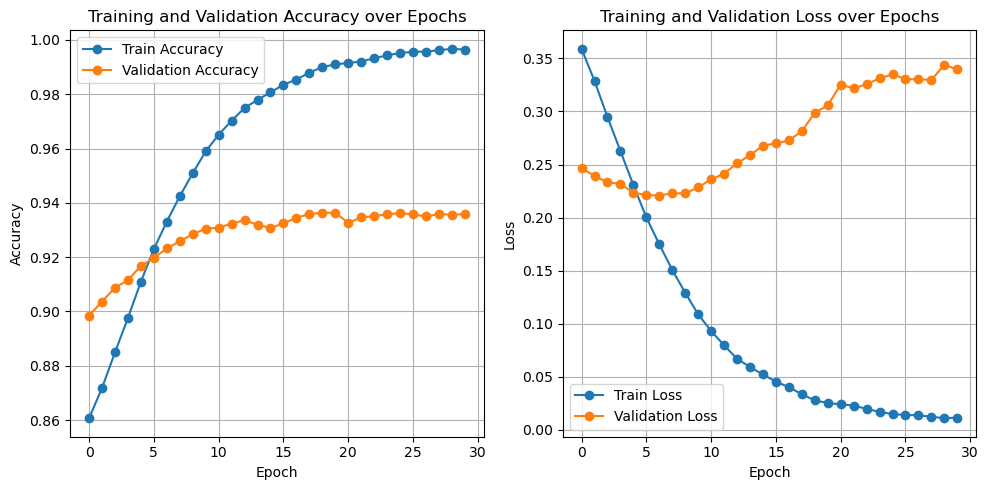

In [56]:
test_model_accuracy(model)

### Two GRU, Two Dense Layer and One Output Layer
#### Increasing the Kernel Size GRUs (128-128)

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(128),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_34 (GRU)                (None, 11, 128)           73344     
                                                                 
 gru_35 (GRU)                (None, 128)               99072     
                                                                 
 dense_49 (Dense)            (None, 16)                2064      
                                                                 
 dense_50 (Dense)            (None, 16)                272       
                                                                 
 dense_51 (Dense)            (None, 3)                 51        
                                                                 
Total params: 174,803
Trainable params: 174,803
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 25ms/step - loss: 0.4373 - accuracy: 0.8312 - val_loss: 0.2784 - val_accuracy: 0.8903
Epoch 2/30
175/175 [==============================] - 3s 19ms/step - loss: 0.2415 - accuracy: 0.9014 - val_loss: 0.2252 - val_accuracy: 0.9071
Epoch 3/30
175/175 [==============================] - 3s 19ms/step - loss: 0.1892 - accuracy: 0.9245 - val_loss: 0.2063 - val_accuracy: 0.9178
Epoch 4/30
175/175 [==============================] - 3s 19ms/step - loss: 0.1545 - accuracy: 0.9388 - val_loss: 0.1883 - val_accuracy: 0.9296
Epoch 5/30
175/175 [==============================] - 3s 19ms/step - loss: 0.1245 - accuracy: 0.9517 - val_loss: 0.1936 - val_accuracy: 0.9314
Epoch 6/30
175/175 [==============================] - 4s 20ms/step - loss: 0.0987 - accuracy: 0.9612 - val_loss: 0.2067 - val_accuracy: 0.9242
Epoch 7/30
175/175 [==============================] - 3s 19ms/step - loss: 0.0812 - accuracy: 0.9702 - val_loss: 0.2199 - val_accuracy: 0.9317

110/110 [==============================] - 1s 6ms/step - loss: 0.4357 - accuracy: 0.9351
Test Accuracy: 93.5087%


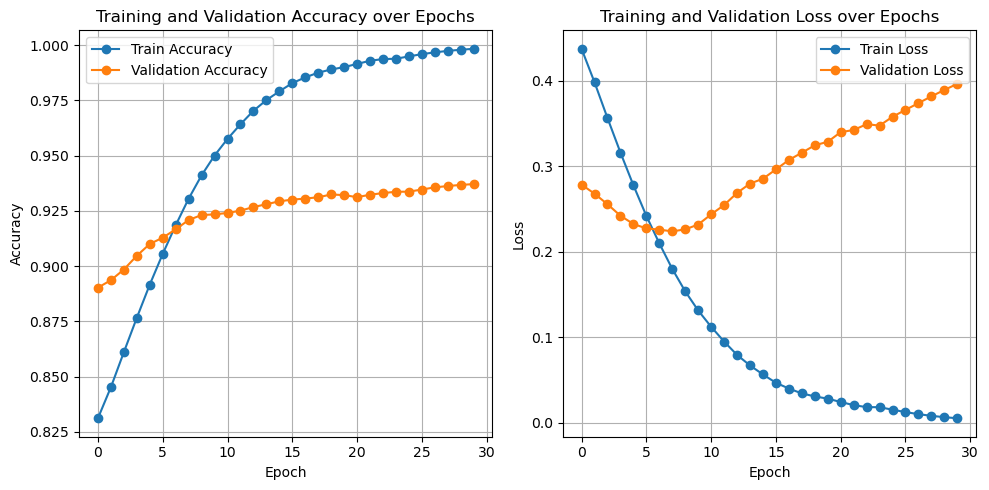

In [59]:
test_model_accuracy(model)

### Two GRU, Two Dense Layer and One Output Layer
#### Increasing the Kernel Size GRUs (64-64)

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(64, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(64),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_38 (GRU)                (None, 11, 64)            24384     
                                                                 
 gru_39 (GRU)                (None, 64)                24960     
                                                                 
 dense_55 (Dense)            (None, 16)                1040      
                                                                 
 dense_56 (Dense)            (None, 16)                272       
                                                                 
 dense_57 (Dense)            (None, 3)                 51        
                                                                 
Total params: 50,707
Trainable params: 50,707
Non-trainable params: 0
_________________________________________________________________


In [62]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 22ms/step - loss: 0.5073 - accuracy: 0.7959 - val_loss: 0.2988 - val_accuracy: 0.8767
Epoch 2/30
175/175 [==============================] - 3s 17ms/step - loss: 0.2605 - accuracy: 0.8908 - val_loss: 0.2565 - val_accuracy: 0.8924
Epoch 3/30
175/175 [==============================] - 3s 17ms/step - loss: 0.2147 - accuracy: 0.9089 - val_loss: 0.2586 - val_accuracy: 0.8953
Epoch 4/30
175/175 [==============================] - 3s 17ms/step - loss: 0.1844 - accuracy: 0.9225 - val_loss: 0.2212 - val_accuracy: 0.9139
Epoch 5/30
175/175 [==============================] - 3s 16ms/step - loss: 0.1484 - accuracy: 0.9384 - val_loss: 0.2177 - val_accuracy: 0.9199
Epoch 6/30
175/175 [==============================] - 3s 17ms/step - loss: 0.1264 - accuracy: 0.9503 - val_loss: 0.2011 - val_accuracy: 0.9278
Epoch 7/30
175/175 [==============================] - 3s 17ms/step - loss: 0.1081 - accuracy: 0.9567 - val_loss: 0.2160 - val_accuracy: 0.9174

110/110 [==============================] - 1s 6ms/step - loss: 0.4741 - accuracy: 0.9297
Test Accuracy: 92.9654%


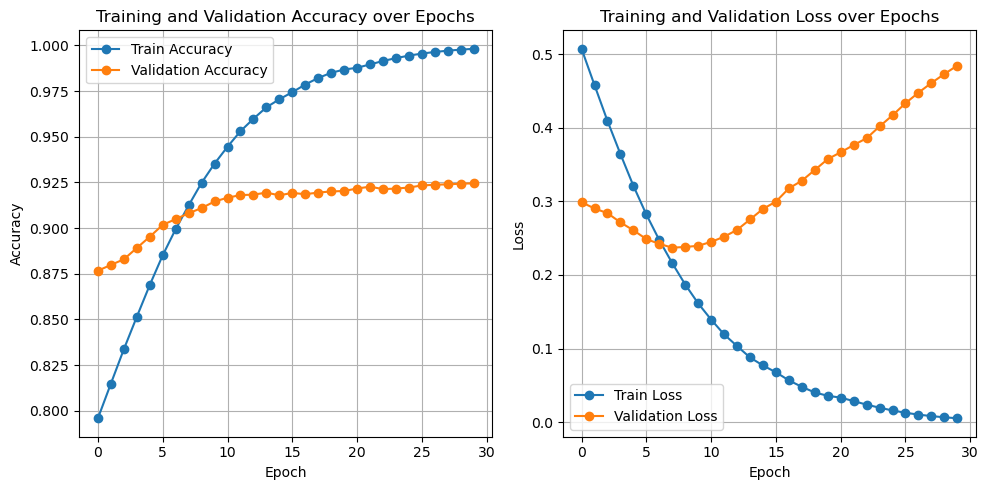

In [63]:
test_model_accuracy(model)

### Two GRU, Two Dense Layer and One Output Layer
#### Increasing the Kernel Size GRUs (256-256)

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(256, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(256),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_40 (GRU)                (None, 11, 256)           244992    
                                                                 
 gru_41 (GRU)                (None, 256)               394752    
                                                                 
 dense_58 (Dense)            (None, 16)                4112      
                                                                 
 dense_59 (Dense)            (None, 16)                272       
                                                                 
 dense_60 (Dense)            (None, 3)                 51        
                                                                 
Total params: 644,179
Trainable params: 644,179
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 10s 36ms/step - loss: 0.3828 - accuracy: 0.8398 - val_loss: 0.2623 - val_accuracy: 0.8939
Epoch 2/30
175/175 [==============================] - 6s 32ms/step - loss: 0.2290 - accuracy: 0.9079 - val_loss: 0.2316 - val_accuracy: 0.9103
Epoch 3/30
175/175 [==============================] - 6s 35ms/step - loss: 0.1779 - accuracy: 0.9283 - val_loss: 0.1944 - val_accuracy: 0.9307
Epoch 4/30
175/175 [==============================] - 6s 33ms/step - loss: 0.1385 - accuracy: 0.9456 - val_loss: 0.2062 - val_accuracy: 0.9282
Epoch 5/30
175/175 [==============================] - 6s 32ms/step - loss: 0.1121 - accuracy: 0.9559 - val_loss: 0.1834 - val_accuracy: 0.9339
Epoch 6/30
175/175 [==============================] - 7s 37ms/step - loss: 0.0935 - accuracy: 0.9630 - val_loss: 0.2330 - val_accuracy: 0.9239
Epoch 7/30
175/175 [==============================] - 6s 35ms/step - loss: 0.0806 - accuracy: 0.9699 - val_loss: 0.2179 - val_accuracy: 0.922

110/110 [==============================] - 1s 9ms/step - loss: 0.3509 - accuracy: 0.9357
Test Accuracy: 93.5659%


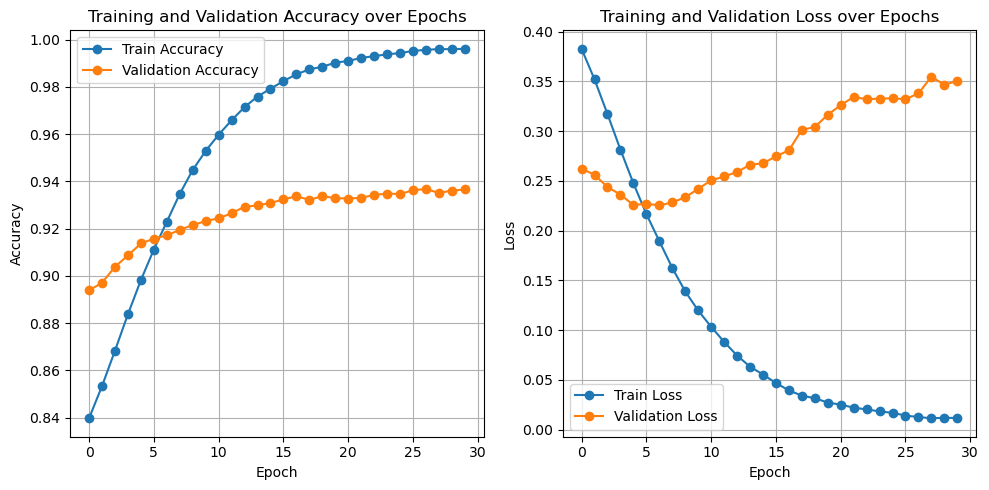

In [66]:
test_model_accuracy(model)

### Two GRU (128-64), Two Dense Layer and One Output Layer (Selected for the Next Step)
#### Changing Specifics of Dense Layers (Making them 32)

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(64),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_42 (GRU)                (None, 11, 128)           73344     
                                                                 
 gru_43 (GRU)                (None, 64)                37248     
                                                                 
 dense_61 (Dense)            (None, 32)                2080      
                                                                 
 dense_62 (Dense)            (None, 32)                1056      
                                                                 
 dense_63 (Dense)            (None, 3)                 99        
                                                                 
Total params: 113,827
Trainable params: 113,827
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 9s 28ms/step - loss: 0.4362 - accuracy: 0.8294 - val_loss: 0.2891 - val_accuracy: 0.8881
Epoch 2/30
175/175 [==============================] - 4s 23ms/step - loss: 0.2462 - accuracy: 0.9020 - val_loss: 0.2459 - val_accuracy: 0.9046
Epoch 3/30
175/175 [==============================] - 4s 24ms/step - loss: 0.1999 - accuracy: 0.9180 - val_loss: 0.2545 - val_accuracy: 0.9081
Epoch 4/30
175/175 [==============================] - 4s 22ms/step - loss: 0.1601 - accuracy: 0.9360 - val_loss: 0.2133 - val_accuracy: 0.9210
Epoch 5/30
175/175 [==============================] - 4s 22ms/step - loss: 0.1298 - accuracy: 0.9485 - val_loss: 0.2156 - val_accuracy: 0.9264
Epoch 6/30
175/175 [==============================] - 4s 23ms/step - loss: 0.1050 - accuracy: 0.9578 - val_loss: 0.2340 - val_accuracy: 0.9221
Epoch 7/30
175/175 [==============================] - 4s 24ms/step - loss: 0.0826 - accuracy: 0.9680 - val_loss: 0.2341 - val_accuracy: 0.9310

110/110 [==============================] - 1s 9ms/step - loss: 0.5151 - accuracy: 0.9322
Test Accuracy: 93.2228%


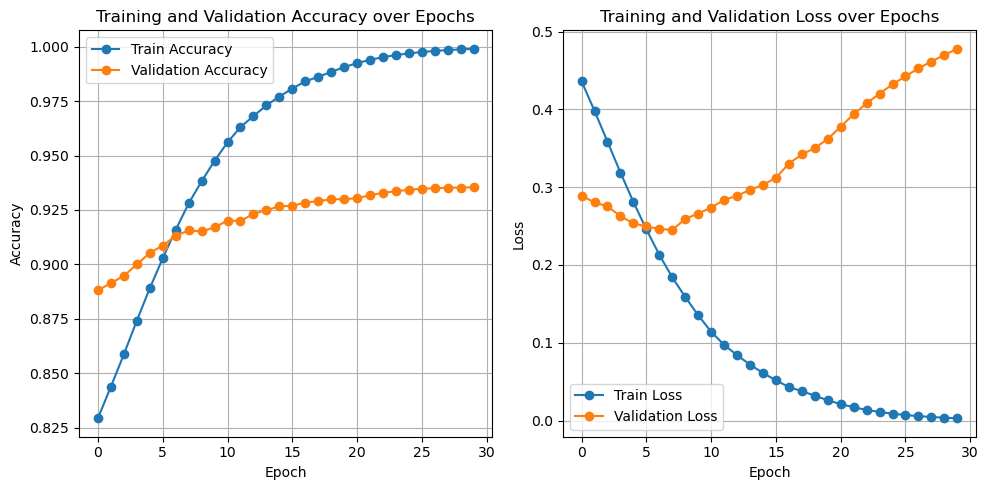

In [70]:
test_model_accuracy(model)

### Two GRU (128-64), Two Dense Layer and One Output Layer (Selected for the Next Step)
#### Changing Specifics of Dense Layers (Making them 64)

In [71]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(64),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_44 (GRU)                (None, 11, 128)           73344     
                                                                 
 gru_45 (GRU)                (None, 64)                37248     
                                                                 
 dense_64 (Dense)            (None, 64)                4160      
                                                                 
 dense_65 (Dense)            (None, 64)                4160      
                                                                 
 dense_66 (Dense)            (None, 3)                 195       
                                                                 
Total params: 119,107
Trainable params: 119,107
Non-trainable params: 0
_________________________________________________________________


In [72]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 9s 29ms/step - loss: 0.3937 - accuracy: 0.8449 - val_loss: 0.2546 - val_accuracy: 0.8899
Epoch 2/30
175/175 [==============================] - 4s 24ms/step - loss: 0.2339 - accuracy: 0.9021 - val_loss: 0.2433 - val_accuracy: 0.9021
Epoch 3/30
175/175 [==============================] - 4s 23ms/step - loss: 0.1915 - accuracy: 0.9200 - val_loss: 0.2090 - val_accuracy: 0.9167
Epoch 4/30
175/175 [==============================] - 4s 23ms/step - loss: 0.1530 - accuracy: 0.9368 - val_loss: 0.2081 - val_accuracy: 0.9224
Epoch 5/30
175/175 [==============================] - 4s 24ms/step - loss: 0.1222 - accuracy: 0.9521 - val_loss: 0.2144 - val_accuracy: 0.9242
Epoch 6/30
175/175 [==============================] - 4s 25ms/step - loss: 0.0958 - accuracy: 0.9632 - val_loss: 0.2263 - val_accuracy: 0.9257
Epoch 7/30
175/175 [==============================] - 4s 23ms/step - loss: 0.0760 - accuracy: 0.9718 - val_loss: 0.2460 - val_accuracy: 0.9110

110/110 [==============================] - 1s 9ms/step - loss: 0.4590 - accuracy: 0.9359
Test Accuracy: 93.5945%


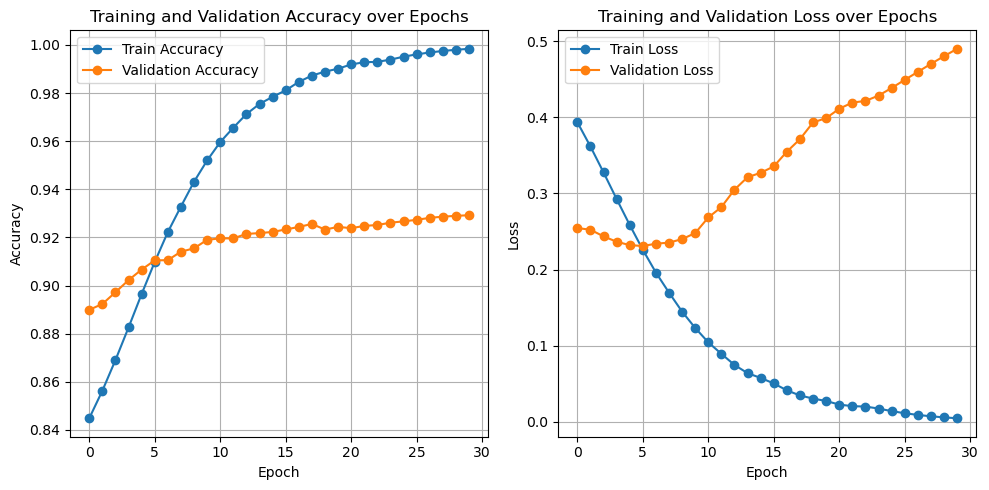

In [73]:
test_model_accuracy(model)

### Two GRU (128-64), Two Dense Layer and One Output Layer (Selected for the Next Step)
#### Changing Specifics of Dense Layers (Making them 64)

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(64),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_46 (GRU)                (None, 11, 128)           73344     
                                                                 
 gru_47 (GRU)                (None, 64)                37248     
                                                                 
 dense_67 (Dense)            (None, 128)               8320      
                                                                 
 dense_68 (Dense)            (None, 128)               16512     
                                                                 
 dense_69 (Dense)            (None, 3)                 387       
                                                                 
Total params: 135,811
Trainable params: 135,811
Non-trainable params: 0
_________________________________________________________________


In [75]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 9s 29ms/step - loss: 0.3927 - accuracy: 0.8415 - val_loss: 0.2784 - val_accuracy: 0.8892
Epoch 2/30
175/175 [==============================] - 4s 24ms/step - loss: 0.2352 - accuracy: 0.9030 - val_loss: 0.2314 - val_accuracy: 0.9067
Epoch 3/30
175/175 [==============================] - 4s 23ms/step - loss: 0.1801 - accuracy: 0.9247 - val_loss: 0.2351 - val_accuracy: 0.9128
Epoch 4/30
175/175 [==============================] - 4s 23ms/step - loss: 0.1424 - accuracy: 0.9425 - val_loss: 0.2084 - val_accuracy: 0.9217
Epoch 5/30
175/175 [==============================] - 4s 25ms/step - loss: 0.1103 - accuracy: 0.9567 - val_loss: 0.2010 - val_accuracy: 0.9260
Epoch 6/30
175/175 [==============================] - 4s 24ms/step - loss: 0.0911 - accuracy: 0.9668 - val_loss: 0.2422 - val_accuracy: 0.9139
Epoch 7/30
175/175 [==============================] - 4s 23ms/step - loss: 0.0764 - accuracy: 0.9709 - val_loss: 0.2171 - val_accuracy: 0.9289

110/110 [==============================] - 1s 9ms/step - loss: 0.5138 - accuracy: 0.9334
Test Accuracy: 93.3371%


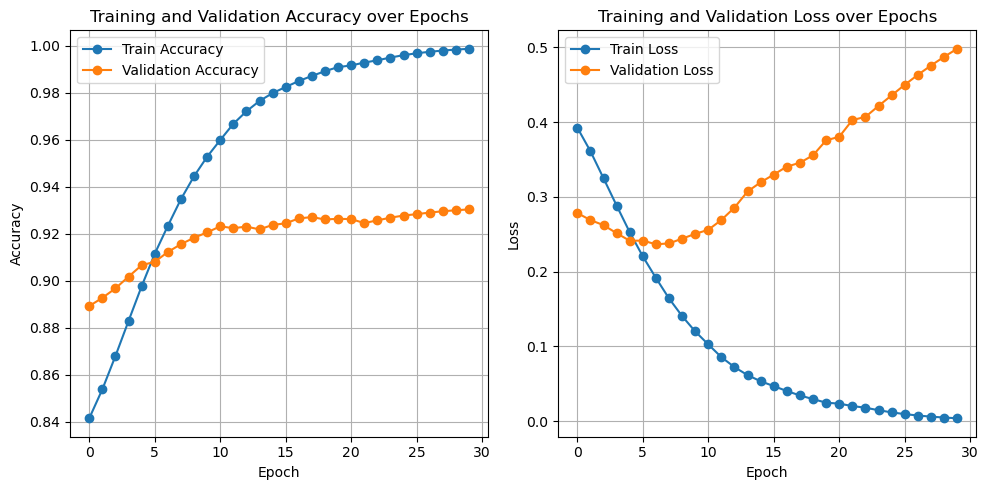

In [76]:
test_model_accuracy(model)

### Two GRU (128-64), Two Dense Layer and One Output Layer (Selected for the Next Step)
#### Changing Specifics of Dense Layers (Making them 8)

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(64),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_48 (GRU)                (None, 11, 128)           73344     
                                                                 
 gru_49 (GRU)                (None, 64)                37248     
                                                                 
 dense_70 (Dense)            (None, 8)                 520       
                                                                 
 dense_71 (Dense)            (None, 8)                 72        
                                                                 
 dense_72 (Dense)            (None, 3)                 27        
                                                                 
Total params: 111,211
Trainable params: 111,211
Non-trainable params: 0
_________________________________________________________________


In [78]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 27ms/step - loss: 0.5041 - accuracy: 0.8188 - val_loss: 0.3325 - val_accuracy: 0.8731
Epoch 2/30
175/175 [==============================] - 4s 24ms/step - loss: 0.2633 - accuracy: 0.8954 - val_loss: 0.2823 - val_accuracy: 0.8892
Epoch 3/30
175/175 [==============================] - 4s 23ms/step - loss: 0.2043 - accuracy: 0.9170 - val_loss: 0.2198 - val_accuracy: 0.9132
Epoch 4/30
175/175 [==============================] - 4s 22ms/step - loss: 0.1686 - accuracy: 0.9327 - val_loss: 0.2069 - val_accuracy: 0.9235
Epoch 5/30
175/175 [==============================] - 4s 22ms/step - loss: 0.1340 - accuracy: 0.9483 - val_loss: 0.1956 - val_accuracy: 0.9310
Epoch 6/30
175/175 [==============================] - 4s 23ms/step - loss: 0.1137 - accuracy: 0.9574 - val_loss: 0.2090 - val_accuracy: 0.9253
Epoch 7/30
175/175 [==============================] - 4s 23ms/step - loss: 0.0872 - accuracy: 0.9673 - val_loss: 0.2013 - val_accuracy: 0.9339

110/110 [==============================] - 1s 9ms/step - loss: 0.4511 - accuracy: 0.9328
Test Accuracy: 93.2800%


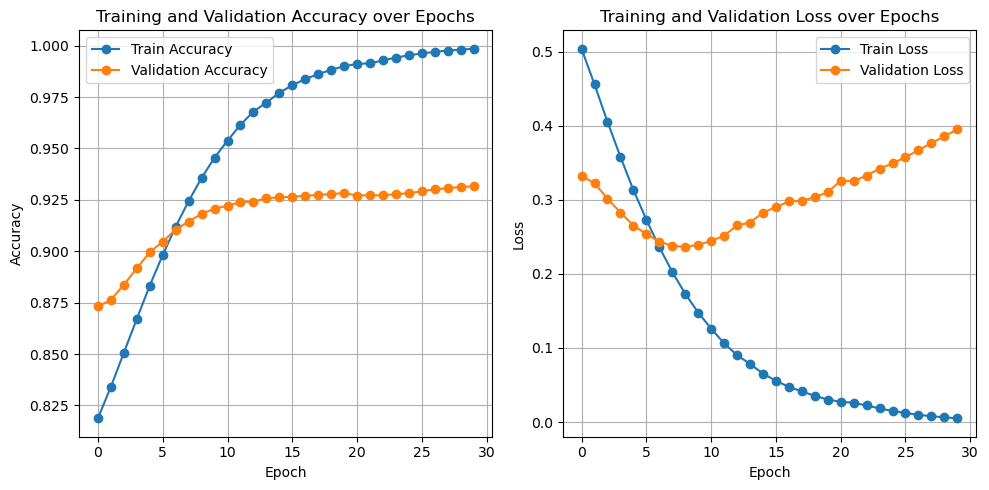

In [79]:
test_model_accuracy(model)

### Two GRU (128-64), Two Dense Layer and One Output Layer (Selected for the Next Step)
#### Changing Specifics of Dense Layers (Making them 32-16)

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(64),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_50 (GRU)                (None, 11, 128)           73344     
                                                                 
 gru_51 (GRU)                (None, 64)                37248     
                                                                 
 dense_73 (Dense)            (None, 32)                2080      
                                                                 
 dense_74 (Dense)            (None, 16)                528       
                                                                 
 dense_75 (Dense)            (None, 3)                 51        
                                                                 
Total params: 113,251
Trainable params: 113,251
Non-trainable params: 0
_________________________________________________________________


In [81]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 27ms/step - loss: 0.4107 - accuracy: 0.8407 - val_loss: 0.2761 - val_accuracy: 0.8835
Epoch 2/30
175/175 [==============================] - 4s 20ms/step - loss: 0.2448 - accuracy: 0.8998 - val_loss: 0.2362 - val_accuracy: 0.9074
Epoch 3/30
175/175 [==============================] - 4s 20ms/step - loss: 0.1980 - accuracy: 0.9182 - val_loss: 0.2414 - val_accuracy: 0.8946
Epoch 4/30
175/175 [==============================] - 4s 21ms/step - loss: 0.1620 - accuracy: 0.9343 - val_loss: 0.1901 - val_accuracy: 0.9307
Epoch 5/30
175/175 [==============================] - 4s 21ms/step - loss: 0.1276 - accuracy: 0.9511 - val_loss: 0.2276 - val_accuracy: 0.9039
Epoch 6/30
175/175 [==============================] - 4s 21ms/step - loss: 0.1005 - accuracy: 0.9609 - val_loss: 0.2183 - val_accuracy: 0.9260
Epoch 7/30
175/175 [==============================] - 4s 20ms/step - loss: 0.0891 - accuracy: 0.9659 - val_loss: 0.1996 - val_accuracy: 0.9335

110/110 [==============================] - 1s 7ms/step - loss: 0.4970 - accuracy: 0.9322
Test Accuracy: 93.2228%


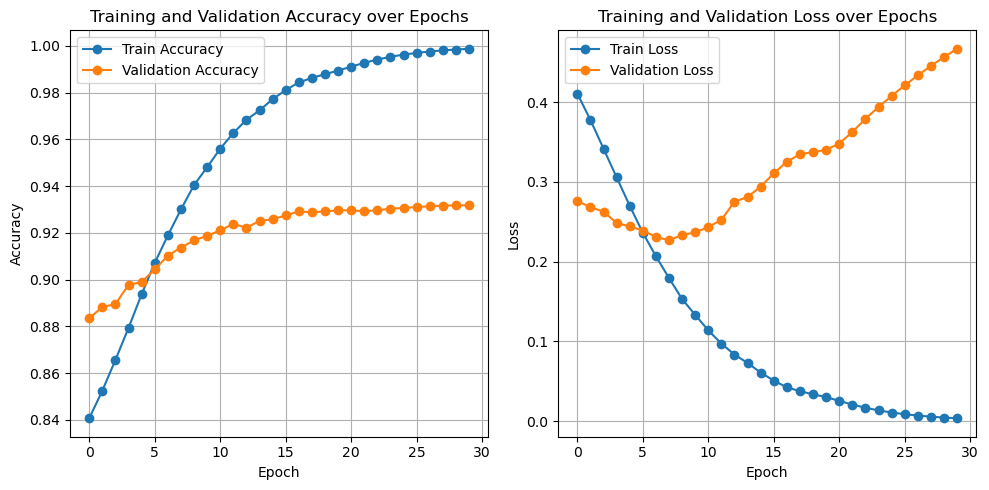

In [82]:
test_model_accuracy(model)

### Two GRU (128-64), Two Dense Layer and One Output Layer (Selected for the Next Step)
#### Changing Specifics of Dense Layers (Making them 16-8)

In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(64),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_54 (GRU)                (None, 11, 128)           73344     
                                                                 
 gru_55 (GRU)                (None, 64)                37248     
                                                                 
 dense_79 (Dense)            (None, 16)                1040      
                                                                 
 dense_80 (Dense)            (None, 8)                 136       
                                                                 
 dense_81 (Dense)            (None, 3)                 27        
                                                                 
Total params: 111,795
Trainable params: 111,795
Non-trainable params: 0
_________________________________________________________________


In [85]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 25ms/step - loss: 0.7615 - accuracy: 0.6791 - val_loss: 0.4294 - val_accuracy: 0.8774
Epoch 2/30
175/175 [==============================] - 3s 20ms/step - loss: 0.2814 - accuracy: 0.8937 - val_loss: 0.2463 - val_accuracy: 0.8960
Epoch 3/30
175/175 [==============================] - 3s 19ms/step - loss: 0.1959 - accuracy: 0.9197 - val_loss: 0.2101 - val_accuracy: 0.9174
Epoch 4/30
175/175 [==============================] - 4s 20ms/step - loss: 0.1624 - accuracy: 0.9334 - val_loss: 0.2097 - val_accuracy: 0.9203
Epoch 5/30
175/175 [==============================] - 3s 19ms/step - loss: 0.1292 - accuracy: 0.9482 - val_loss: 0.2102 - val_accuracy: 0.9235
Epoch 6/30
175/175 [==============================] - 3s 19ms/step - loss: 0.1109 - accuracy: 0.9562 - val_loss: 0.2050 - val_accuracy: 0.9253
Epoch 7/30
175/175 [==============================] - 3s 19ms/step - loss: 0.0818 - accuracy: 0.9680 - val_loss: 0.2499 - val_accuracy: 0.9207

110/110 [==============================] - 1s 7ms/step - loss: 0.3837 - accuracy: 0.9362
Test Accuracy: 93.6231%


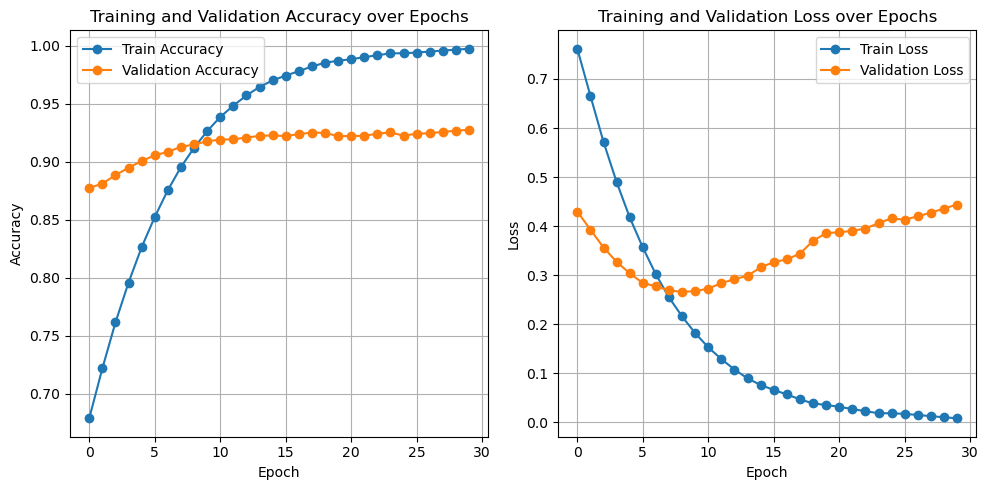

In [86]:
test_model_accuracy(model)

## Adding Flatten Layer

In [87]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(64),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_56 (GRU)                (None, 11, 128)           73344     
                                                                 
 gru_57 (GRU)                (None, 64)                37248     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_82 (Dense)            (None, 16)                1040      
                                                                 
 dense_83 (Dense)            (None, 16)                272       
                                                                 
 dense_84 (Dense)            (None, 3)                 51        
                                                                 
Total params: 111,955
Trainable params: 111,955
Non-t

In [88]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 25ms/step - loss: 0.4395 - accuracy: 0.8282 - val_loss: 0.3104 - val_accuracy: 0.8781
Epoch 2/30
175/175 [==============================] - 4s 21ms/step - loss: 0.2431 - accuracy: 0.8998 - val_loss: 0.2407 - val_accuracy: 0.9014
Epoch 3/30
175/175 [==============================] - 4s 21ms/step - loss: 0.1883 - accuracy: 0.9217 - val_loss: 0.2060 - val_accuracy: 0.9196
Epoch 4/30
175/175 [==============================] - 4s 20ms/step - loss: 0.1537 - accuracy: 0.9399 - val_loss: 0.2028 - val_accuracy: 0.9260
Epoch 5/30
175/175 [==============================] - 3s 20ms/step - loss: 0.1306 - accuracy: 0.9480 - val_loss: 0.2129 - val_accuracy: 0.9217
Epoch 6/30
175/175 [==============================] - 4s 21ms/step - loss: 0.1047 - accuracy: 0.9605 - val_loss: 0.2231 - val_accuracy: 0.9285
Epoch 7/30
175/175 [==============================] - 4s 21ms/step - loss: 0.0882 - accuracy: 0.9661 - val_loss: 0.2166 - val_accuracy: 0.9332

110/110 [==============================] - 1s 7ms/step - loss: 0.4530 - accuracy: 0.9325
Test Accuracy: 93.2514%


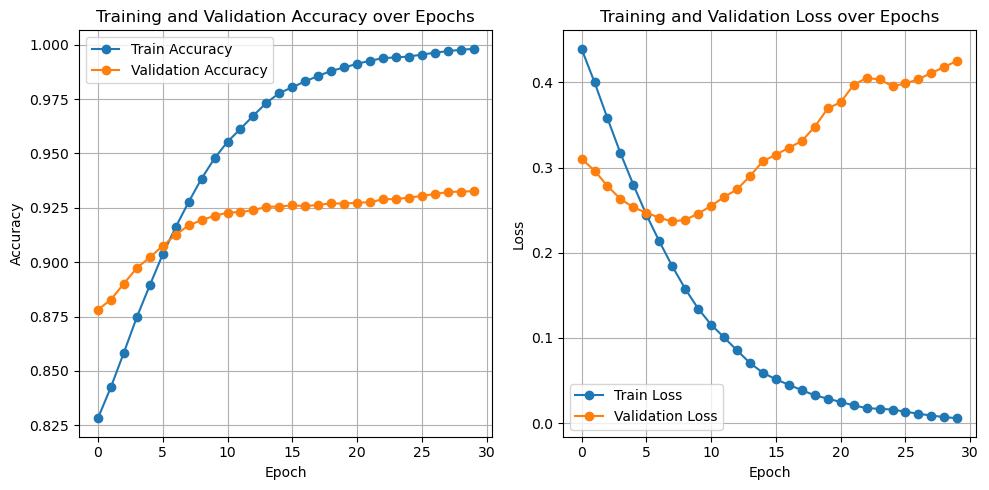

In [89]:
test_model_accuracy(model)

## Adding Batch Normalization
### Only 1 Batch Normalization Layer After First GRU

In [93]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    BatchNormalization(),
    GRU(64),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_60 (GRU)                (None, 11, 128)           73344     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 128)          512       
 hNormalization)                                                 
                                                                 
 gru_61 (GRU)                (None, 64)                37248     
                                                                 
 dense_88 (Dense)            (None, 16)                1040      
                                                                 
 dense_89 (Dense)            (None, 16)                272       
                                                                 
 dense_90 (Dense)            (None, 3)                 51        
                                                     

In [94]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 25ms/step - loss: 0.4146 - accuracy: 0.8295 - val_loss: 0.3051 - val_accuracy: 0.8713
Epoch 2/30
175/175 [==============================] - 4s 22ms/step - loss: 0.2444 - accuracy: 0.8971 - val_loss: 0.2395 - val_accuracy: 0.9003
Epoch 3/30
175/175 [==============================] - 4s 20ms/step - loss: 0.1913 - accuracy: 0.9219 - val_loss: 0.2496 - val_accuracy: 0.9035
Epoch 4/30
175/175 [==============================] - 4s 21ms/step - loss: 0.1526 - accuracy: 0.9373 - val_loss: 0.2061 - val_accuracy: 0.9210
Epoch 5/30
175/175 [==============================] - 4s 20ms/step - loss: 0.1251 - accuracy: 0.9513 - val_loss: 0.2057 - val_accuracy: 0.9228
Epoch 6/30
175/175 [==============================] - 4s 21ms/step - loss: 0.0977 - accuracy: 0.9626 - val_loss: 0.2089 - val_accuracy: 0.9192
Epoch 7/30
175/175 [==============================] - 4s 22ms/step - loss: 0.0831 - accuracy: 0.9688 - val_loss: 0.2161 - val_accuracy: 0.9189

110/110 [==============================] - 1s 7ms/step - loss: 0.4413 - accuracy: 0.9308
Test Accuracy: 93.0798%


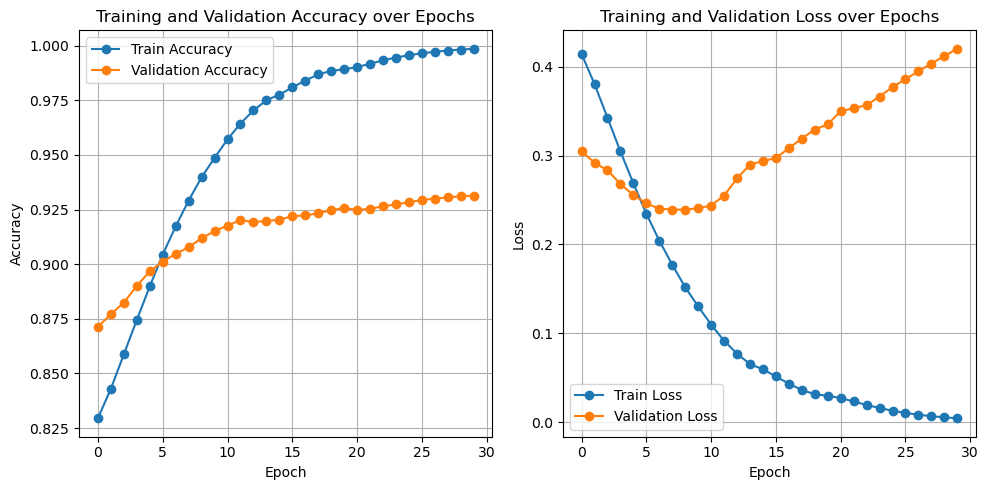

In [95]:
test_model_accuracy(model)

## Adding Batch Normalization
### Only 1 Batch Normalization Layer After Second GRU

In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    GRU(64),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_58 (GRU)                (None, 11, 128)           73344     
                                                                 
 gru_59 (GRU)                (None, 64)                37248     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_85 (Dense)            (None, 16)                1040      
                                                                 
 dense_86 (Dense)            (None, 16)                272       
                                                                 
 dense_87 (Dense)            (None, 3)                 51        
                                                     

In [91]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 26ms/step - loss: 0.4083 - accuracy: 0.8387 - val_loss: 0.3155 - val_accuracy: 0.8771
Epoch 2/30
175/175 [==============================] - 4s 20ms/step - loss: 0.2427 - accuracy: 0.9008 - val_loss: 0.2880 - val_accuracy: 0.8967
Epoch 3/30
175/175 [==============================] - 4s 20ms/step - loss: 0.1985 - accuracy: 0.9176 - val_loss: 0.2173 - val_accuracy: 0.9064
Epoch 4/30
175/175 [==============================] - 3s 20ms/step - loss: 0.1606 - accuracy: 0.9337 - val_loss: 0.2047 - val_accuracy: 0.9253
Epoch 5/30
175/175 [==============================] - 4s 20ms/step - loss: 0.1298 - accuracy: 0.9491 - val_loss: 0.1952 - val_accuracy: 0.9335
Epoch 6/30
175/175 [==============================] - 4s 21ms/step - loss: 0.1093 - accuracy: 0.9575 - val_loss: 0.2001 - val_accuracy: 0.9299
Epoch 7/30
175/175 [==============================] - 4s 20ms/step - loss: 0.0918 - accuracy: 0.9630 - val_loss: 0.2044 - val_accuracy: 0.9339

110/110 [==============================] - 1s 7ms/step - loss: 0.4214 - accuracy: 0.9345
Test Accuracy: 93.4515%


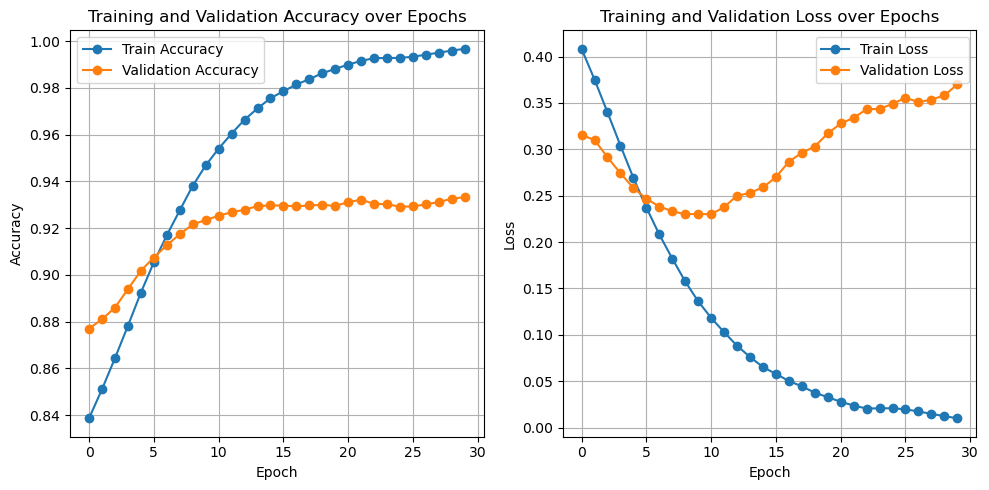

In [92]:
test_model_accuracy(model)

## Adding Batch Normalization
### Two Batch Normalization Layer After GRUs

In [97]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    BatchNormalization(),
    GRU(64),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_64 (GRU)                (None, 11, 128)           73344     
                                                                 
 batch_normalization_4 (Batc  (None, 11, 128)          512       
 hNormalization)                                                 
                                                                 
 gru_65 (GRU)                (None, 64)                37248     
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_94 (Dense)            (None, 16)                1040      
                                                                 
 dense_95 (Dense)            (None, 16)              

In [98]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 26ms/step - loss: 0.4317 - accuracy: 0.8218 - val_loss: 0.3677 - val_accuracy: 0.8560
Epoch 2/30
175/175 [==============================] - 3s 19ms/step - loss: 0.2520 - accuracy: 0.8958 - val_loss: 0.2590 - val_accuracy: 0.8981
Epoch 3/30
175/175 [==============================] - 3s 20ms/step - loss: 0.2035 - accuracy: 0.9167 - val_loss: 0.2267 - val_accuracy: 0.9153
Epoch 4/30
175/175 [==============================] - 4s 20ms/step - loss: 0.1629 - accuracy: 0.9379 - val_loss: 0.2076 - val_accuracy: 0.9182
Epoch 5/30
175/175 [==============================] - 3s 19ms/step - loss: 0.1314 - accuracy: 0.9468 - val_loss: 0.1882 - val_accuracy: 0.9335
Epoch 6/30
175/175 [==============================] - 3s 19ms/step - loss: 0.1119 - accuracy: 0.9576 - val_loss: 0.2159 - val_accuracy: 0.9221
Epoch 7/30
175/175 [==============================] - 3s 19ms/step - loss: 0.0905 - accuracy: 0.9648 - val_loss: 0.2153 - val_accuracy: 0.9278

110/110 [==============================] - 1s 6ms/step - loss: 0.3934 - accuracy: 0.9365
Test Accuracy: 93.6517%


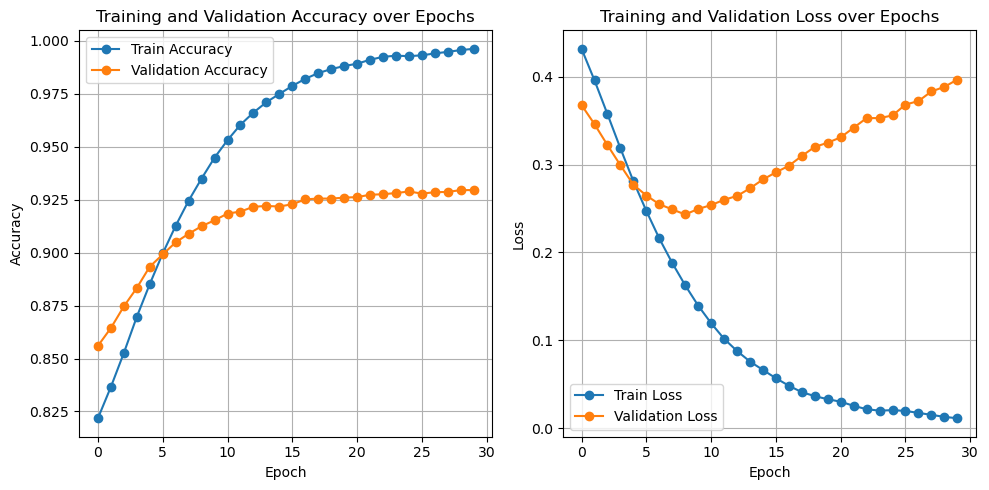

In [99]:
test_model_accuracy(model)

## Adding Pooling Layers (Selected for Next Stage)
### Testing Average Pooling Layers

In [101]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    
    GRU(64,return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_68 (GRU)                (None, 11, 128)           73344     
                                                                 
 batch_normalization_8 (Batc  (None, 11, 128)          512       
 hNormalization)                                                 
                                                                 
 average_pooling1d_1 (Averag  (None, 5, 128)           0         
 ePooling1D)                                                     
                                                                 
 gru_69 (GRU)                (None, 5, 64)             37248     
                                                                 
 batch_normalization_9 (Batc  (None, 5, 64)            256       
 hNormalization)                                                 
                                                     

In [102]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 20ms/step - loss: 0.4877 - accuracy: 0.8026 - val_loss: 0.3568 - val_accuracy: 0.8603
Epoch 2/30
175/175 [==============================] - 3s 15ms/step - loss: 0.2765 - accuracy: 0.8850 - val_loss: 0.2859 - val_accuracy: 0.8838
Epoch 3/30
175/175 [==============================] - 3s 15ms/step - loss: 0.2171 - accuracy: 0.9102 - val_loss: 0.2413 - val_accuracy: 0.9049
Epoch 4/30
175/175 [==============================] - 3s 15ms/step - loss: 0.1785 - accuracy: 0.9300 - val_loss: 0.2167 - val_accuracy: 0.9189
Epoch 5/30
175/175 [==============================] - 3s 15ms/step - loss: 0.1448 - accuracy: 0.9408 - val_loss: 0.1962 - val_accuracy: 0.9285
Epoch 6/30
175/175 [==============================] - 3s 15ms/step - loss: 0.1200 - accuracy: 0.9534 - val_loss: 0.2023 - val_accuracy: 0.9282
Epoch 7/30
175/175 [==============================] - 3s 15ms/step - loss: 0.1036 - accuracy: 0.9593 - val_loss: 0.2114 - val_accuracy: 0.9239

110/110 [==============================] - 1s 6ms/step - loss: 0.4090 - accuracy: 0.9305
Test Accuracy: 93.0512%


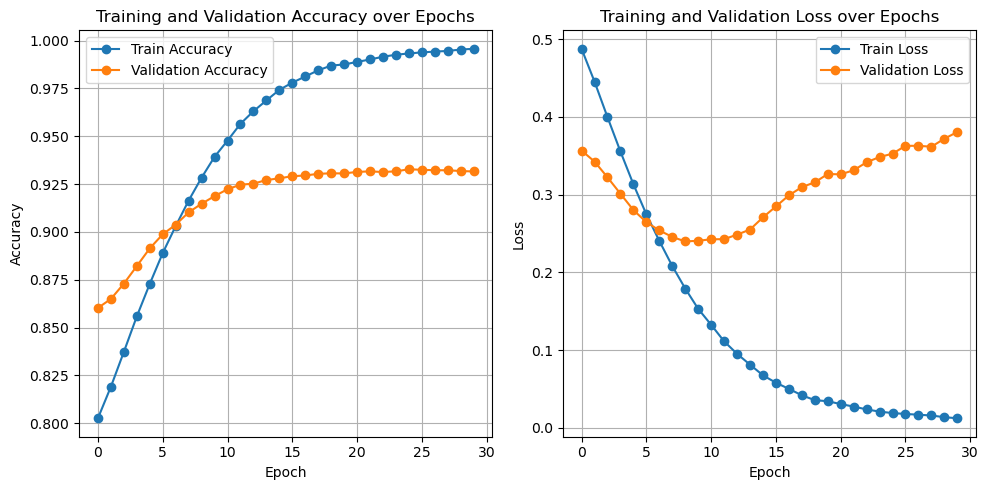

In [103]:
test_model_accuracy(model)

## Adding Pooling Layers
### Testing Max Pooling Layers

In [104]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    GRU(64,return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),

    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_70 (GRU)                (None, 11, 128)           73344     
                                                                 
 batch_normalization_10 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 128)           0         
 )                                                               
                                                                 
 gru_71 (GRU)                (None, 5, 64)             37248     
                                                                 
 batch_normalization_11 (Bat  (None, 5, 64)            256       
 chNormalization)                                                
                                                     

In [105]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 21ms/step - loss: 0.4149 - accuracy: 0.8319 - val_loss: 0.4325 - val_accuracy: 0.8363
Epoch 2/30
175/175 [==============================] - 3s 16ms/step - loss: 0.2480 - accuracy: 0.8977 - val_loss: 0.2361 - val_accuracy: 0.9089
Epoch 3/30
175/175 [==============================] - 3s 16ms/step - loss: 0.1961 - accuracy: 0.9195 - val_loss: 0.2669 - val_accuracy: 0.8964
Epoch 4/30
175/175 [==============================] - 3s 16ms/step - loss: 0.1548 - accuracy: 0.9393 - val_loss: 0.2363 - val_accuracy: 0.9157
Epoch 5/30
175/175 [==============================] - 3s 16ms/step - loss: 0.1336 - accuracy: 0.9488 - val_loss: 0.2226 - val_accuracy: 0.9142
Epoch 6/30
175/175 [==============================] - 3s 17ms/step - loss: 0.0998 - accuracy: 0.9629 - val_loss: 0.2377 - val_accuracy: 0.9046
Epoch 7/30
175/175 [==============================] - 3s 16ms/step - loss: 0.0790 - accuracy: 0.9719 - val_loss: 0.2637 - val_accuracy: 0.9089

110/110 [==============================] - 1s 5ms/step - loss: 0.3931 - accuracy: 0.9257
Test Accuracy: 92.5651%


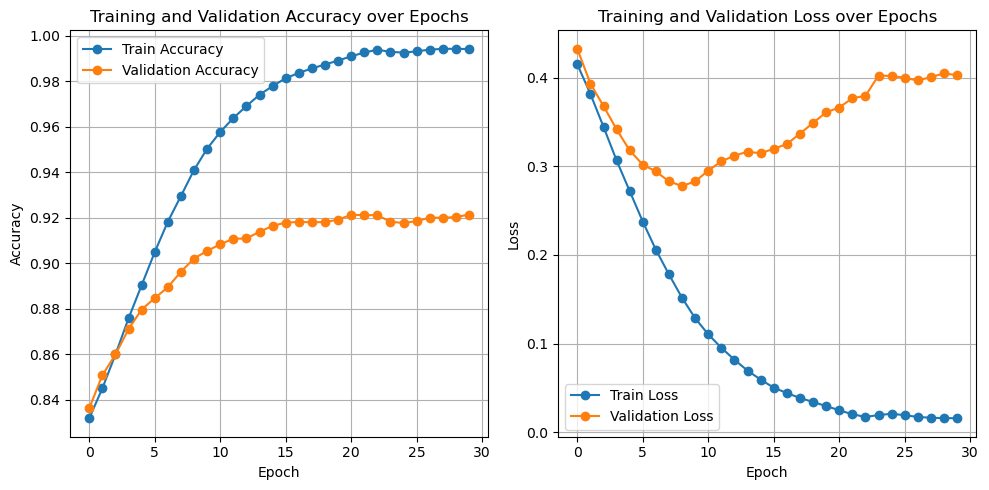

In [106]:
test_model_accuracy(model)

## Adding Dropout Layers

In [109]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_72 (GRU)                (None, 11, 128)           73344     
                                                                 
 batch_normalization_12 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_2 (Averag  (None, 5, 128)           0         
 ePooling1D)                                                     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 gru_73 (GRU)                (None, 5, 64)             37248     
                                                                 
 batch_normalization_13 (Bat  (None, 5, 64)          

In [110]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 8s 23ms/step - loss: 0.7202 - accuracy: 0.6697 - val_loss: 0.5167 - val_accuracy: 0.8006
Epoch 2/30
175/175 [==============================] - 3s 19ms/step - loss: 0.4690 - accuracy: 0.8111 - val_loss: 0.3533 - val_accuracy: 0.8592
Epoch 3/30
175/175 [==============================] - 3s 19ms/step - loss: 0.3881 - accuracy: 0.8483 - val_loss: 0.2858 - val_accuracy: 0.8792
Epoch 4/30
175/175 [==============================] - 3s 18ms/step - loss: 0.3357 - accuracy: 0.8698 - val_loss: 0.2699 - val_accuracy: 0.8910
Epoch 5/30
175/175 [==============================] - 3s 18ms/step - loss: 0.2990 - accuracy: 0.8846 - val_loss: 0.2562 - val_accuracy: 0.8910
Epoch 6/30
175/175 [==============================] - 3s 19ms/step - loss: 0.2643 - accuracy: 0.8954 - val_loss: 0.2415 - val_accuracy: 0.9021
Epoch 7/30
175/175 [==============================] - 3s 19ms/step - loss: 0.2478 - accuracy: 0.9032 - val_loss: 0.2454 - val_accuracy: 0.9060

110/110 [==============================] - 1s 6ms/step - loss: 0.4271 - accuracy: 0.9297
Test Accuracy: 92.9654%


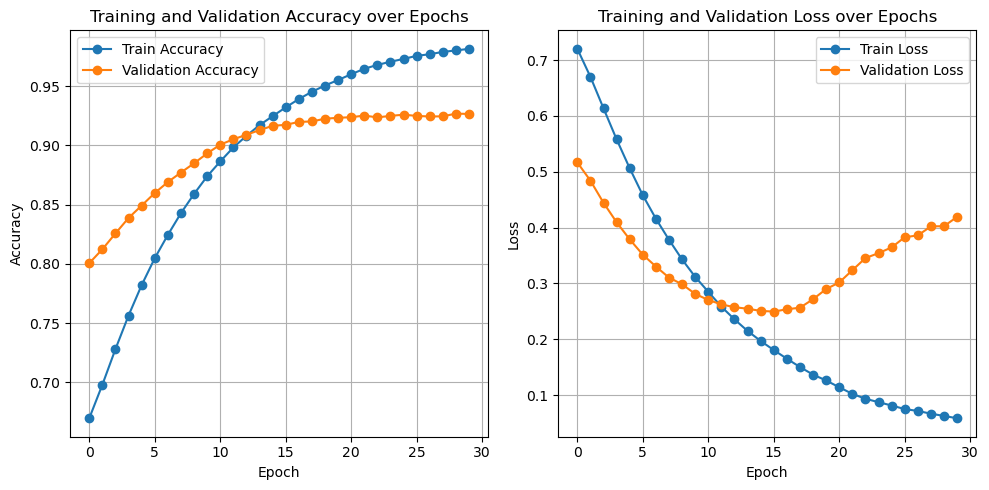

In [111]:
test_model_accuracy(model)

## Complex Architecture

In [121]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    BatchNormalization(),
    GRU(128,return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,return_sequences=True),
    BatchNormalization(),
    GRU(64,return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_86 (GRU)                (None, 11, 128)           73344     
                                                                 
 batch_normalization_22 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_87 (GRU)                (None, 11, 128)           99072     
                                                                 
 batch_normalization_23 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_6 (Averag  (None, 5, 128)           0         
 ePooling1D)                                                     
                                                     

In [122]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 15s 42ms/step - loss: 0.6642 - accuracy: 0.7135 - val_loss: 0.4668 - val_accuracy: 0.8238
Epoch 2/30
175/175 [==============================] - 6s 32ms/step - loss: 0.4038 - accuracy: 0.8427 - val_loss: 0.3126 - val_accuracy: 0.8681
Epoch 3/30
175/175 [==============================] - 6s 31ms/step - loss: 0.3477 - accuracy: 0.8673 - val_loss: 0.2635 - val_accuracy: 0.8946
Epoch 4/30
175/175 [==============================] - 6s 32ms/step - loss: 0.2883 - accuracy: 0.8892 - val_loss: 0.2501 - val_accuracy: 0.9028
Epoch 5/30
175/175 [==============================] - 6s 32ms/step - loss: 0.2587 - accuracy: 0.9004 - val_loss: 0.2509 - val_accuracy: 0.9021
Epoch 6/30
175/175 [==============================] - 6s 34ms/step - loss: 0.2359 - accuracy: 0.9132 - val_loss: 0.2297 - val_accuracy: 0.9167
Epoch 7/30
175/175 [==============================] - 6s 35ms/step - loss: 0.2086 - accuracy: 0.9227 - val_loss: 0.2254 - val_accuracy: 0.918

110/110 [==============================] - 1s 10ms/step - loss: 0.4749 - accuracy: 0.9302
Test Accuracy: 93.0226%


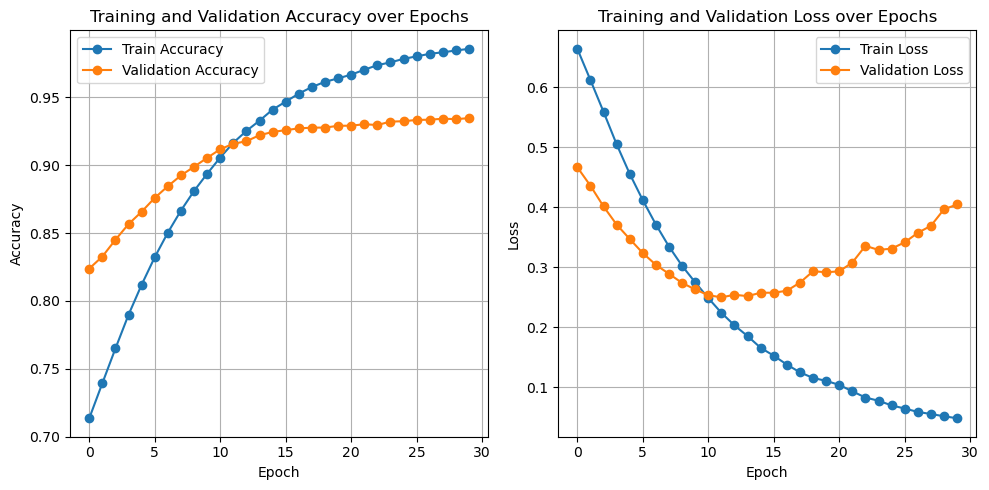

In [123]:
test_model_accuracy(model)

## Tweaking the Complex Model

In [124]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),return_sequences=True),
    BatchNormalization(),
    GRU(128,return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    GRU(64,return_sequences=True),
    BatchNormalization(),
    GRU(64,return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),

    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_90 (GRU)                (None, 11, 128)           73344     
                                                                 
 batch_normalization_26 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_91 (GRU)                (None, 11, 128)           99072     
                                                                 
 batch_normalization_27 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_7 (Averag  (None, 5, 128)           0         
 ePooling1D)                                                     
                                                     

In [125]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 15s 41ms/step - loss: 0.7633 - accuracy: 0.6540 - val_loss: 0.5319 - val_accuracy: 0.7909
Epoch 2/30
175/175 [==============================] - 5s 31ms/step - loss: 0.4883 - accuracy: 0.8110 - val_loss: 0.3288 - val_accuracy: 0.8645
Epoch 3/30
175/175 [==============================] - 6s 32ms/step - loss: 0.3902 - accuracy: 0.8518 - val_loss: 0.2806 - val_accuracy: 0.8888
Epoch 4/30
175/175 [==============================] - 6s 32ms/step - loss: 0.3472 - accuracy: 0.8703 - val_loss: 0.3176 - val_accuracy: 0.8731
Epoch 5/30
175/175 [==============================] - 5s 31ms/step - loss: 0.3091 - accuracy: 0.8847 - val_loss: 0.2580 - val_accuracy: 0.9060
Epoch 6/30
175/175 [==============================] - 6s 36ms/step - loss: 0.2742 - accuracy: 0.9022 - val_loss: 0.2247 - val_accuracy: 0.9178
Epoch 7/30
175/175 [==============================] - 6s 35ms/step - loss: 0.2404 - accuracy: 0.9150 - val_loss: 0.2281 - val_accuracy: 0.919

110/110 [==============================] - 1s 10ms/step - loss: 0.3867 - accuracy: 0.9291
Test Accuracy: 92.9082%


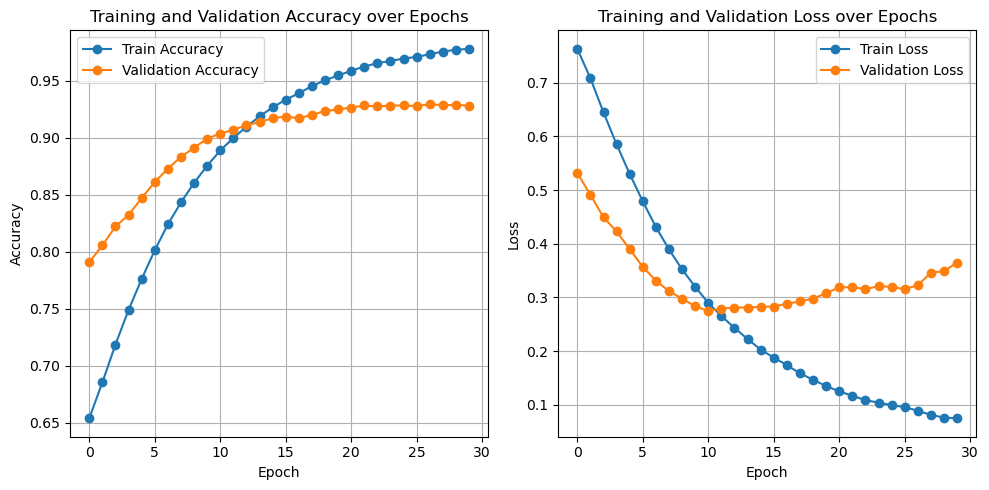

In [126]:
test_model_accuracy(model)

## Selected Model Complex Model with Average Pooling Layers
### Testing with Different Activation Functions

In [127]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_94 (GRU)                (None, 11, 128)           73344     
                                                                 
 batch_normalization_30 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_95 (GRU)                (None, 11, 128)           99072     
                                                                 
 batch_normalization_31 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_8 (Averag  (None, 5, 128)           0         
 ePooling1D)                                                     
                                                     

In [128]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 33ms/step - loss: 0.6617 - accuracy: 0.7189 - val_loss: 0.9964 - val_accuracy: 0.5179
Epoch 2/30
175/175 [==============================] - 5s 28ms/step - loss: 0.4073 - accuracy: 0.8437 - val_loss: 0.4501 - val_accuracy: 0.8081
Epoch 3/30
175/175 [==============================] - 5s 28ms/step - loss: 0.3432 - accuracy: 0.8647 - val_loss: 0.2948 - val_accuracy: 0.8813
Epoch 4/30
175/175 [==============================] - 5s 27ms/step - loss: 0.3050 - accuracy: 0.8814 - val_loss: 0.2394 - val_accuracy: 0.9149
Epoch 5/30
175/175 [==============================] - 5s 27ms/step - loss: 0.2715 - accuracy: 0.8959 - val_loss: 0.2382 - val_accuracy: 0.9078
Epoch 6/30
175/175 [==============================] - 5s 29ms/step - loss: 0.2574 - accuracy: 0.9048 - val_loss: 0.2513 - val_accuracy: 0.8996
Epoch 7/30
175/175 [==============================] - 5s 29ms/step - loss: 0.2280 - accuracy: 0.9119 - val_loss: 0.2011 - val_accuracy: 0.918

110/110 [==============================] - 1s 9ms/step - loss: 0.2036 - accuracy: 0.9434
Test Accuracy: 94.3380%


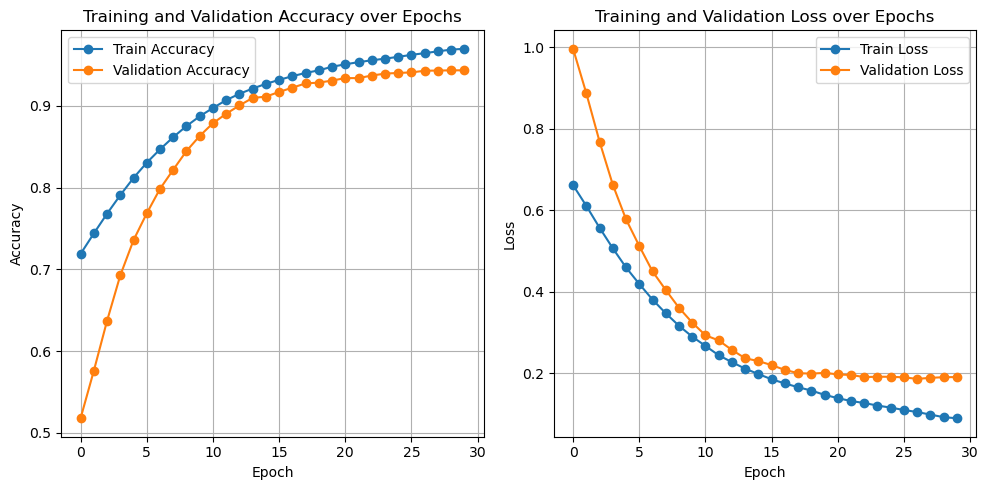

In [129]:
test_model_accuracy(model)

## Tweaked Model
### Testing with Different Activation Functions

In [130]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    GRU(64,activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),

    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_98 (GRU)                (None, 11, 128)           73344     
                                                                 
 batch_normalization_34 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_99 (GRU)                (None, 11, 128)           99072     
                                                                 
 batch_normalization_35 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_9 (Averag  (None, 5, 128)           0         
 ePooling1D)                                                     
                                                     

In [131]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 31ms/step - loss: 0.6942 - accuracy: 0.7020 - val_loss: 1.0525 - val_accuracy: 0.3224
Epoch 2/30
175/175 [==============================] - 5s 27ms/step - loss: 0.4382 - accuracy: 0.8328 - val_loss: 0.4840 - val_accuracy: 0.7859
Epoch 3/30
175/175 [==============================] - 5s 28ms/step - loss: 0.3916 - accuracy: 0.8534 - val_loss: 0.2895 - val_accuracy: 0.8931
Epoch 4/30
175/175 [==============================] - 5s 28ms/step - loss: 0.3367 - accuracy: 0.8763 - val_loss: 0.2513 - val_accuracy: 0.9049
Epoch 5/30
175/175 [==============================] - 5s 27ms/step - loss: 0.3065 - accuracy: 0.8859 - val_loss: 0.2693 - val_accuracy: 0.8824
Epoch 6/30
175/175 [==============================] - 5s 27ms/step - loss: 0.2636 - accuracy: 0.9068 - val_loss: 0.2805 - val_accuracy: 0.8956
Epoch 7/30
175/175 [==============================] - 5s 30ms/step - loss: 0.2463 - accuracy: 0.9117 - val_loss: 0.2204 - val_accuracy: 0.916

110/110 [==============================] - 1s 8ms/step - loss: 0.2135 - accuracy: 0.9434
Test Accuracy: 94.3380%


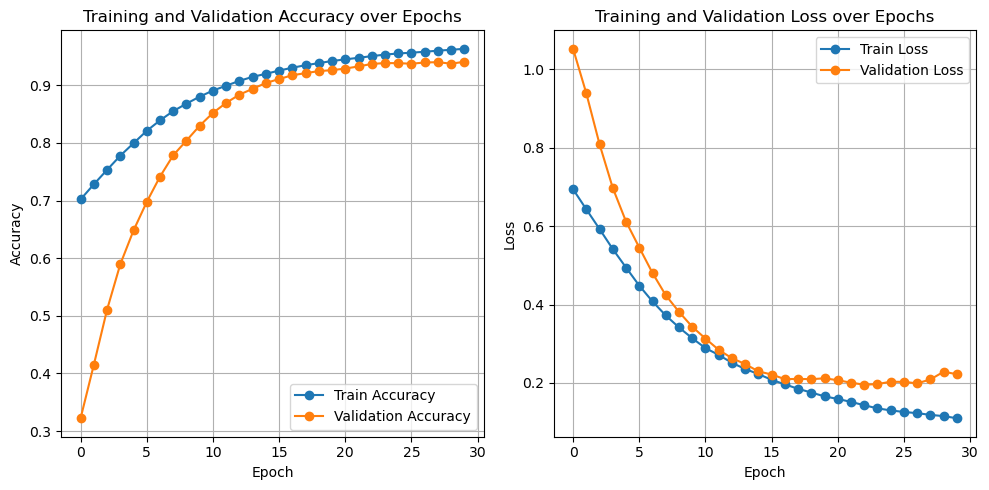

In [132]:
test_model_accuracy(model)

## Selected Model Complex Model with Average Pooling Layers (Selected for Next Stage)
### Adding Recurrent Activation (Selected For Final)

In [133]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_102 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_38 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_103 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_39 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_10 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [134]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 34ms/step - loss: 0.6248 - accuracy: 0.7398 - val_loss: 1.0424 - val_accuracy: 0.4167
Epoch 2/30
175/175 [==============================] - 5s 30ms/step - loss: 0.4172 - accuracy: 0.8366 - val_loss: 0.4123 - val_accuracy: 0.8631
Epoch 3/30
175/175 [==============================] - 5s 28ms/step - loss: 0.3656 - accuracy: 0.8593 - val_loss: 0.2771 - val_accuracy: 0.8956
Epoch 4/30
175/175 [==============================] - 5s 30ms/step - loss: 0.3259 - accuracy: 0.8738 - val_loss: 0.2781 - val_accuracy: 0.8892
Epoch 5/30
175/175 [==============================] - 5s 29ms/step - loss: 0.2890 - accuracy: 0.8891 - val_loss: 0.3144 - val_accuracy: 0.8553
Epoch 6/30
175/175 [==============================] - 5s 28ms/step - loss: 0.2520 - accuracy: 0.9008 - val_loss: 0.2184 - val_accuracy: 0.9164
Epoch 7/30
175/175 [==============================] - 5s 31ms/step - loss: 0.2441 - accuracy: 0.9072 - val_loss: 0.2197 - val_accuracy: 0.916

110/110 [==============================] - 1s 9ms/step - loss: 0.2232 - accuracy: 0.9500
Test Accuracy: 94.9957%


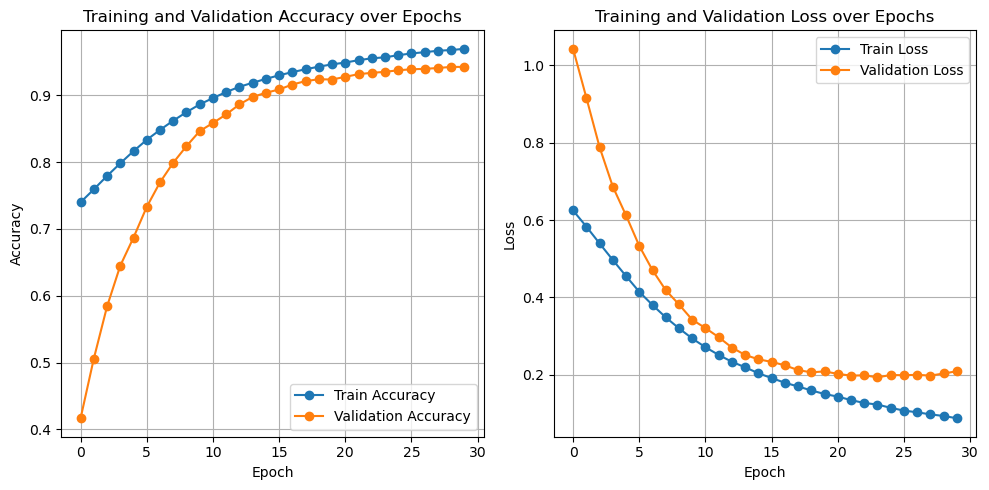

In [135]:
test_model_accuracy(model)

## Selected Model Complex Model with Average Pooling Layers
### Testing with "tanh" Activation Function

In [136]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_106 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_42 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_107 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_43 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_11 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [137]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 15s 38ms/step - loss: 0.6708 - accuracy: 0.7163 - val_loss: 0.5149 - val_accuracy: 0.8002
Epoch 2/30
175/175 [==============================] - 5s 29ms/step - loss: 0.4278 - accuracy: 0.8334 - val_loss: 0.3218 - val_accuracy: 0.8685
Epoch 3/30
175/175 [==============================] - 5s 30ms/step - loss: 0.3488 - accuracy: 0.8659 - val_loss: 0.2668 - val_accuracy: 0.8871
Epoch 4/30
175/175 [==============================] - 5s 29ms/step - loss: 0.3020 - accuracy: 0.8816 - val_loss: 0.2548 - val_accuracy: 0.8956
Epoch 5/30
175/175 [==============================] - 5s 29ms/step - loss: 0.2688 - accuracy: 0.8949 - val_loss: 0.2545 - val_accuracy: 0.9089
Epoch 6/30
175/175 [==============================] - 5s 30ms/step - loss: 0.2383 - accuracy: 0.9068 - val_loss: 0.2606 - val_accuracy: 0.9010
Epoch 7/30
175/175 [==============================] - 5s 31ms/step - loss: 0.2089 - accuracy: 0.9219 - val_loss: 0.2448 - val_accuracy: 0.908

110/110 [==============================] - 1s 8ms/step - loss: 0.4264 - accuracy: 0.9337
Test Accuracy: 93.3657%


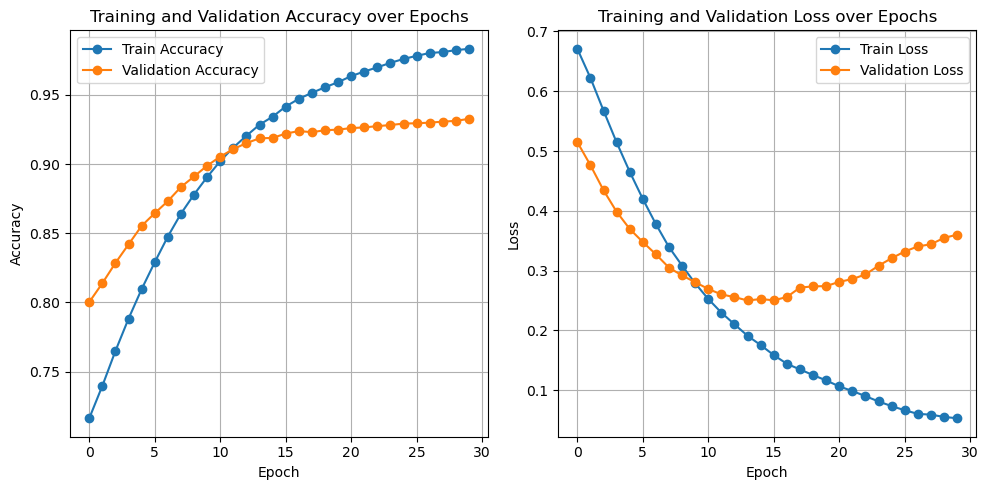

In [138]:
test_model_accuracy(model)

## Selected Model Complex Model with Average Pooling Layers
### Testing with "tanh" Recurrent Activation Function

In [139]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='tanh',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='tanh',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',recurrent_activation='tanh',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_110 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_46 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_111 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_47 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_12 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [140]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 12s 34ms/step - loss: 0.6460 - accuracy: 0.7223 - val_loss: 0.9001 - val_accuracy: 0.5822
Epoch 2/30
175/175 [==============================] - 5s 28ms/step - loss: 0.3634 - accuracy: 0.8629 - val_loss: 0.2676 - val_accuracy: 0.8906
Epoch 3/30
175/175 [==============================] - 5s 27ms/step - loss: 0.2946 - accuracy: 0.8936 - val_loss: 0.2517 - val_accuracy: 0.9139
Epoch 4/30
175/175 [==============================] - 5s 27ms/step - loss: 0.2360 - accuracy: 0.9169 - val_loss: 0.2150 - val_accuracy: 0.9203
Epoch 5/30
175/175 [==============================] - 5s 28ms/step - loss: 0.2081 - accuracy: 0.9281 - val_loss: 0.2075 - val_accuracy: 0.9235
Epoch 6/30
175/175 [==============================] - 5s 27ms/step - loss: 0.1987 - accuracy: 0.9335 - val_loss: 0.1903 - val_accuracy: 0.9249
Epoch 7/30
175/175 [==============================] - 5s 29ms/step - loss: 0.1644 - accuracy: 0.9434 - val_loss: 0.1950 - val_accuracy: 0.929

110/110 [==============================] - 1s 8ms/step - loss: 0.3552 - accuracy: 0.9357
Test Accuracy: 93.5659%


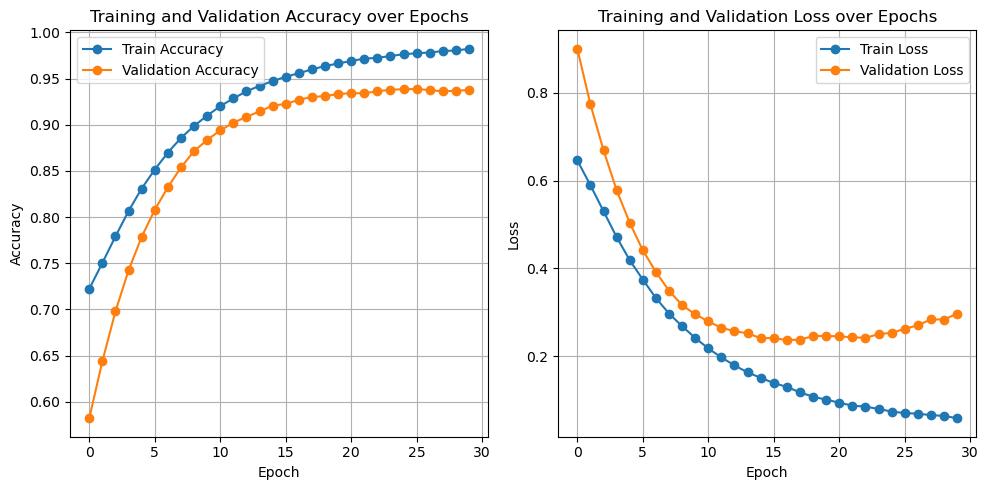

In [141]:
test_model_accuracy(model)

## Selected Model Complex Model with Average Pooling Layers
### Testing with "Linear" Activation Function

In [142]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='linear',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='linear',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='linear',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='linear',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_114 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_50 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_115 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_51 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_13 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [143]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 31ms/step - loss: 0.6485 - accuracy: 0.7235 - val_loss: 0.3913 - val_accuracy: 0.8556
Epoch 2/30
175/175 [==============================] - 5s 29ms/step - loss: 0.4050 - accuracy: 0.8443 - val_loss: 0.3064 - val_accuracy: 0.8763
Epoch 3/30
175/175 [==============================] - 5s 28ms/step - loss: 0.3324 - accuracy: 0.8708 - val_loss: 0.2539 - val_accuracy: 0.9049
Epoch 4/30
175/175 [==============================] - 5s 27ms/step - loss: 0.2662 - accuracy: 0.9028 - val_loss: 0.2411 - val_accuracy: 0.9121
Epoch 5/30
175/175 [==============================] - 5s 28ms/step - loss: 0.2371 - accuracy: 0.9152 - val_loss: 0.2040 - val_accuracy: 0.9328
Epoch 6/30
175/175 [==============================] - 5s 28ms/step - loss: 0.2069 - accuracy: 0.9287 - val_loss: 0.1963 - val_accuracy: 0.9364
Epoch 7/30
175/175 [==============================] - 5s 28ms/step - loss: 0.1927 - accuracy: 0.9327 - val_loss: 0.2505 - val_accuracy: 0.906

110/110 [==============================] - 1s 9ms/step - loss: 0.4624 - accuracy: 0.9337
Test Accuracy: 93.3657%


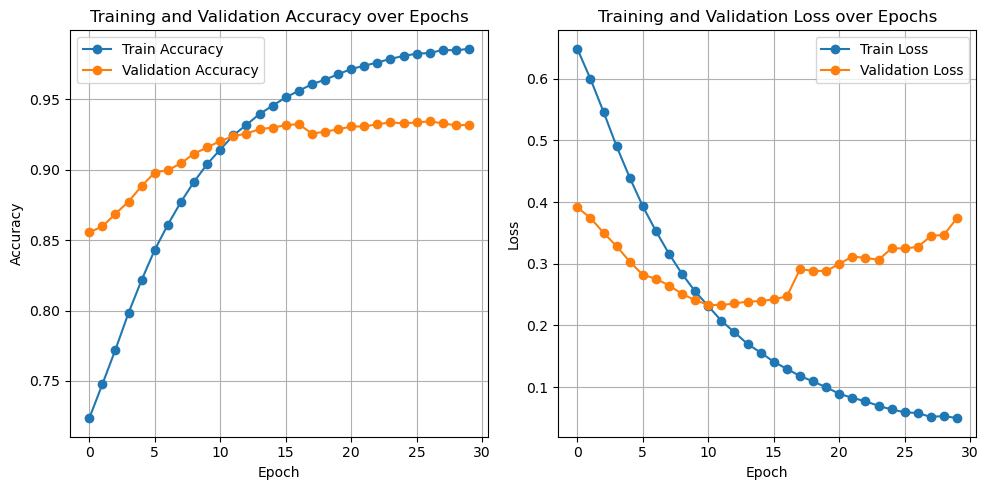

In [144]:
test_model_accuracy(model)

## Selected Model Complex Model with Average Pooling Layers
### Testing with "Relu" Activation Function

In [145]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='relu',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='relu',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='relu',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='relu',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_118 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_54 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_119 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_55 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_14 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [146]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 32ms/step - loss: 0.6335 - accuracy: 0.7265 - val_loss: 0.4572 - val_accuracy: 0.8424
Epoch 2/30
175/175 [==============================] - 5s 27ms/step - loss: 0.3874 - accuracy: 0.8496 - val_loss: 0.2837 - val_accuracy: 0.8867
Epoch 3/30
175/175 [==============================] - 5s 30ms/step - loss: 0.3185 - accuracy: 0.8811 - val_loss: 0.3029 - val_accuracy: 0.8781
Epoch 4/30
175/175 [==============================] - 5s 28ms/step - loss: 0.2650 - accuracy: 0.8992 - val_loss: 0.2738 - val_accuracy: 0.9021
Epoch 5/30
175/175 [==============================] - 5s 27ms/step - loss: 0.2344 - accuracy: 0.9130 - val_loss: 0.2154 - val_accuracy: 0.9232
Epoch 6/30
175/175 [==============================] - 5s 29ms/step - loss: 0.2169 - accuracy: 0.9213 - val_loss: 0.2155 - val_accuracy: 0.9174
Epoch 7/30
175/175 [==============================] - 5s 29ms/step - loss: 0.1824 - accuracy: 0.9355 - val_loss: 0.1982 - val_accuracy: 0.932

110/110 [==============================] - 1s 8ms/step - loss: 0.3401 - accuracy: 0.9414
Test Accuracy: 94.1378%


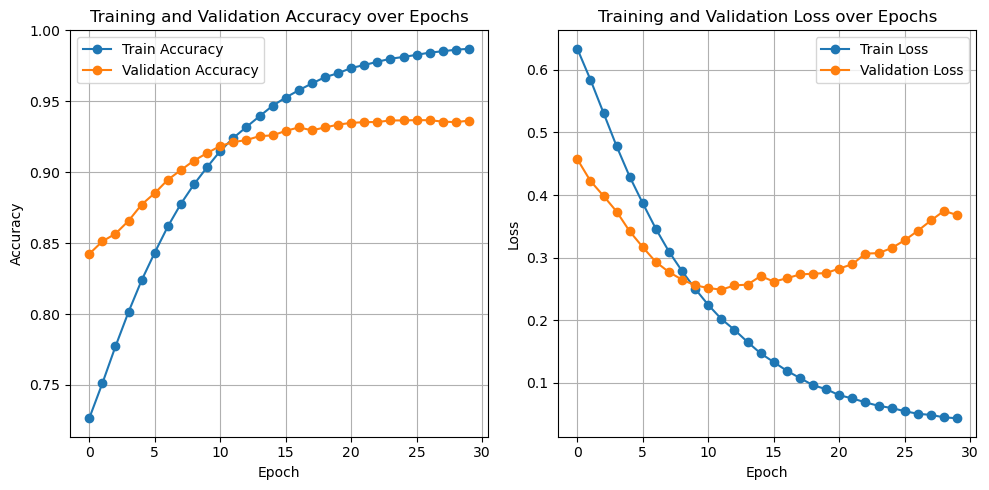

In [147]:
test_model_accuracy(model)

## More Tweaking The Selected Model

In [148]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.4),
    
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.4),

    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_122 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_58 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_123 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_59 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_15 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [149]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 12s 33ms/step - loss: 0.8015 - accuracy: 0.6327 - val_loss: 1.0194 - val_accuracy: 0.3413
Epoch 2/30
175/175 [==============================] - 5s 29ms/step - loss: 0.5211 - accuracy: 0.8062 - val_loss: 0.4961 - val_accuracy: 0.8081
Epoch 3/30
175/175 [==============================] - 5s 28ms/step - loss: 0.4431 - accuracy: 0.8454 - val_loss: 0.3245 - val_accuracy: 0.8620
Epoch 4/30
175/175 [==============================] - 5s 28ms/step - loss: 0.3925 - accuracy: 0.8581 - val_loss: 0.3478 - val_accuracy: 0.8517
Epoch 5/30
175/175 [==============================] - 5s 30ms/step - loss: 0.3641 - accuracy: 0.8694 - val_loss: 0.3271 - val_accuracy: 0.8631
Epoch 6/30
175/175 [==============================] - 5s 29ms/step - loss: 0.3312 - accuracy: 0.8817 - val_loss: 0.2289 - val_accuracy: 0.9164
Epoch 7/30
175/175 [==============================] - 5s 31ms/step - loss: 0.3066 - accuracy: 0.8893 - val_loss: 0.2300 - val_accuracy: 0.913

110/110 [==============================] - 1s 8ms/step - loss: 0.1895 - accuracy: 0.9462
Test Accuracy: 94.6240%


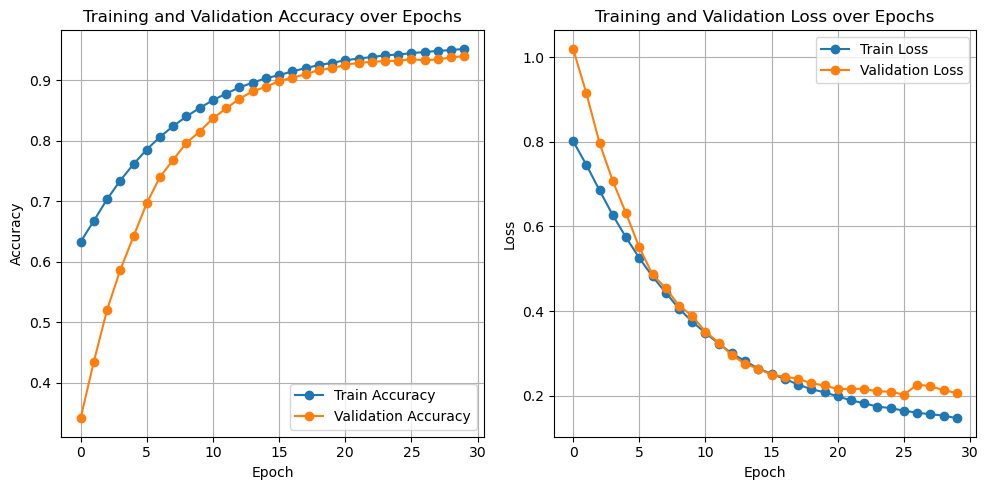

In [150]:
test_model_accuracy(model)

## Selected Model Complex Model
### Changing Learning Rate to 0.002

In [151]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_126 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_62 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_127 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_63 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_16 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [152]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 12s 33ms/step - loss: 0.5666 - accuracy: 0.7646 - val_loss: 0.9289 - val_accuracy: 0.5997
Epoch 2/30
175/175 [==============================] - 5s 29ms/step - loss: 0.3760 - accuracy: 0.8531 - val_loss: 0.2878 - val_accuracy: 0.8928
Epoch 3/30
175/175 [==============================] - 5s 29ms/step - loss: 0.3166 - accuracy: 0.8797 - val_loss: 0.2385 - val_accuracy: 0.9103
Epoch 4/30
175/175 [==============================] - 5s 29ms/step - loss: 0.2752 - accuracy: 0.8954 - val_loss: 0.2618 - val_accuracy: 0.8992
Epoch 5/30
175/175 [==============================] - 5s 29ms/step - loss: 0.2561 - accuracy: 0.9041 - val_loss: 0.1905 - val_accuracy: 0.9274
Epoch 6/30
175/175 [==============================] - 5s 30ms/step - loss: 0.2138 - accuracy: 0.9194 - val_loss: 0.1881 - val_accuracy: 0.9285
Epoch 7/30
175/175 [==============================] - 5s 31ms/step - loss: 0.2131 - accuracy: 0.9211 - val_loss: 0.2674 - val_accuracy: 0.901

110/110 [==============================] - 1s 9ms/step - loss: 0.2455 - accuracy: 0.9434
Test Accuracy: 94.3380%


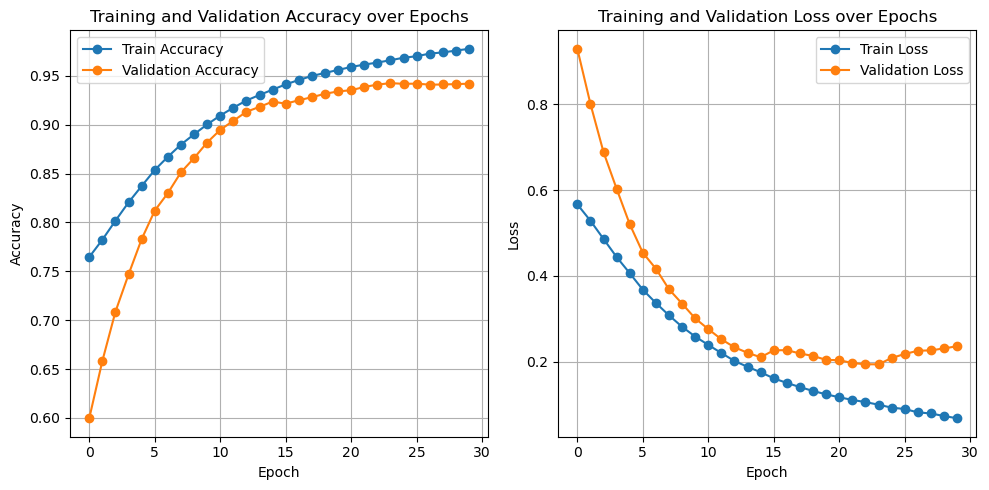

In [153]:
test_model_accuracy(model)

### Changing Learning Rate to 0.0005

In [154]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_130 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_66 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_131 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_67 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_17 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [155]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 12s 34ms/step - loss: 0.7272 - accuracy: 0.6539 - val_loss: 1.0737 - val_accuracy: 0.5322
Epoch 2/30
175/175 [==============================] - 5s 29ms/step - loss: 0.4830 - accuracy: 0.8055 - val_loss: 0.5608 - val_accuracy: 0.8249
Epoch 3/30
175/175 [==============================] - 5s 29ms/step - loss: 0.4147 - accuracy: 0.8324 - val_loss: 0.3037 - val_accuracy: 0.8792
Epoch 4/30
175/175 [==============================] - 6s 33ms/step - loss: 0.3649 - accuracy: 0.8589 - val_loss: 0.3113 - val_accuracy: 0.8881
Epoch 5/30
175/175 [==============================] - 5s 29ms/step - loss: 0.3435 - accuracy: 0.8622 - val_loss: 0.3057 - val_accuracy: 0.8760
Epoch 6/30
175/175 [==============================] - 5s 29ms/step - loss: 0.3074 - accuracy: 0.8783 - val_loss: 0.2348 - val_accuracy: 0.9039
Epoch 7/30
175/175 [==============================] - 6s 33ms/step - loss: 0.2860 - accuracy: 0.8881 - val_loss: 0.2313 - val_accuracy: 0.910

110/110 [==============================] - 1s 9ms/step - loss: 0.1879 - accuracy: 0.9471
Test Accuracy: 94.7098%


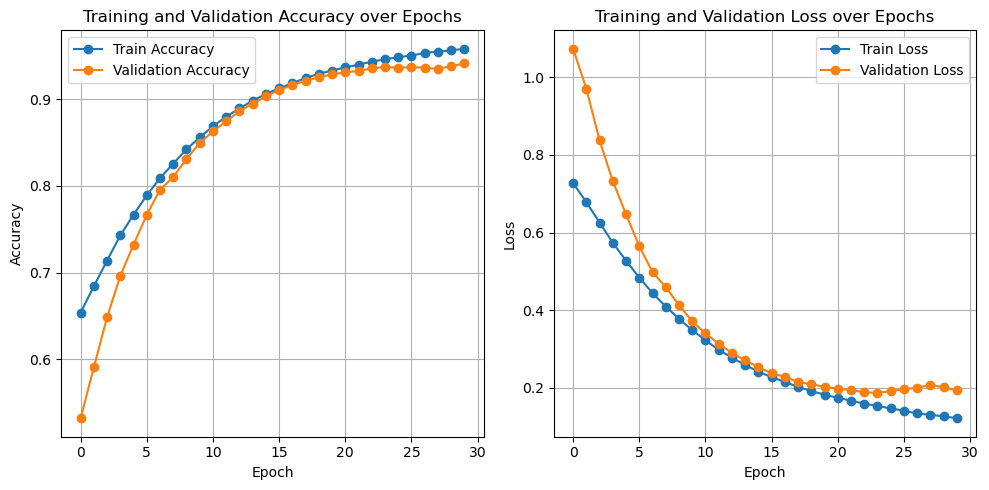

In [156]:
test_model_accuracy(model)

### Changing Learning Rate to 0.0015

In [157]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_134 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_70 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_135 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_71 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_18 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [158]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 12s 35ms/step - loss: 0.5903 - accuracy: 0.7618 - val_loss: 0.8384 - val_accuracy: 0.7888
Epoch 2/30
175/175 [==============================] - 5s 29ms/step - loss: 0.3850 - accuracy: 0.8606 - val_loss: 0.3317 - val_accuracy: 0.8717
Epoch 3/30
175/175 [==============================] - 6s 32ms/step - loss: 0.3236 - accuracy: 0.8798 - val_loss: 0.2994 - val_accuracy: 0.8756
Epoch 4/30
175/175 [==============================] - 5s 29ms/step - loss: 0.2826 - accuracy: 0.8978 - val_loss: 0.2494 - val_accuracy: 0.8992
Epoch 5/30
175/175 [==============================] - 5s 30ms/step - loss: 0.2431 - accuracy: 0.9113 - val_loss: 0.2029 - val_accuracy: 0.9214
Epoch 6/30
175/175 [==============================] - 6s 35ms/step - loss: 0.2253 - accuracy: 0.9176 - val_loss: 0.2050 - val_accuracy: 0.9192
Epoch 7/30
175/175 [==============================] - 6s 33ms/step - loss: 0.2157 - accuracy: 0.9195 - val_loss: 0.2407 - val_accuracy: 0.907

110/110 [==============================] - 1s 9ms/step - loss: 0.1985 - accuracy: 0.9431
Test Accuracy: 94.3094%


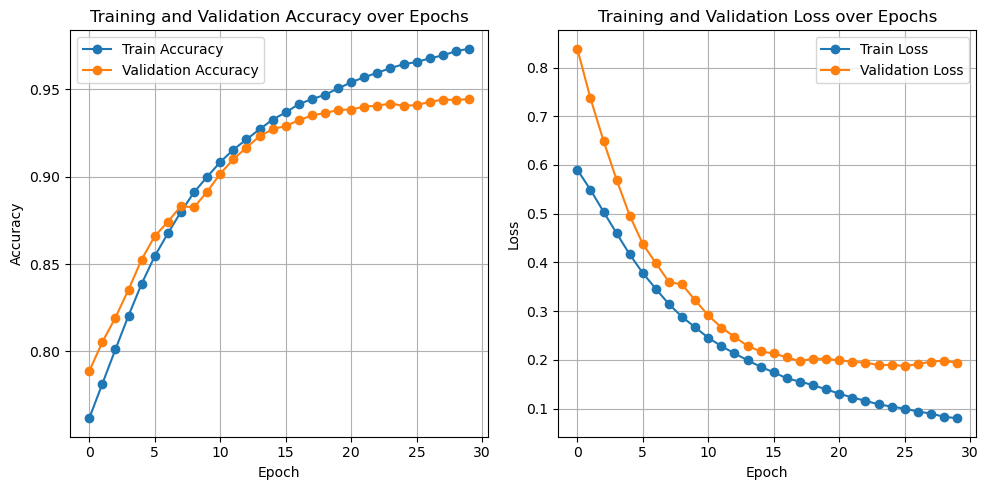

In [159]:
test_model_accuracy(model)

### Changing the Epsilon Value 2e-07

In [160]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=2e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_138 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_74 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_139 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_75 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_19 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [161]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 12s 34ms/step - loss: 0.6574 - accuracy: 0.7175 - val_loss: 0.9705 - val_accuracy: 0.6505
Epoch 2/30
175/175 [==============================] - 5s 29ms/step - loss: 0.4045 - accuracy: 0.8385 - val_loss: 0.3631 - val_accuracy: 0.8628
Epoch 3/30
175/175 [==============================] - 5s 31ms/step - loss: 0.3491 - accuracy: 0.8692 - val_loss: 0.2490 - val_accuracy: 0.8992
Epoch 4/30
175/175 [==============================] - 5s 29ms/step - loss: 0.3073 - accuracy: 0.8792 - val_loss: 0.2767 - val_accuracy: 0.8896
Epoch 5/30
175/175 [==============================] - 5s 29ms/step - loss: 0.2847 - accuracy: 0.8927 - val_loss: 0.2250 - val_accuracy: 0.9060
Epoch 6/30
175/175 [==============================] - 5s 31ms/step - loss: 0.2515 - accuracy: 0.9056 - val_loss: 0.2242 - val_accuracy: 0.9224
Epoch 7/30
175/175 [==============================] - 5s 31ms/step - loss: 0.2311 - accuracy: 0.9129 - val_loss: 0.2494 - val_accuracy: 0.911

110/110 [==============================] - 1s 9ms/step - loss: 0.2712 - accuracy: 0.9271
Test Accuracy: 92.7080%


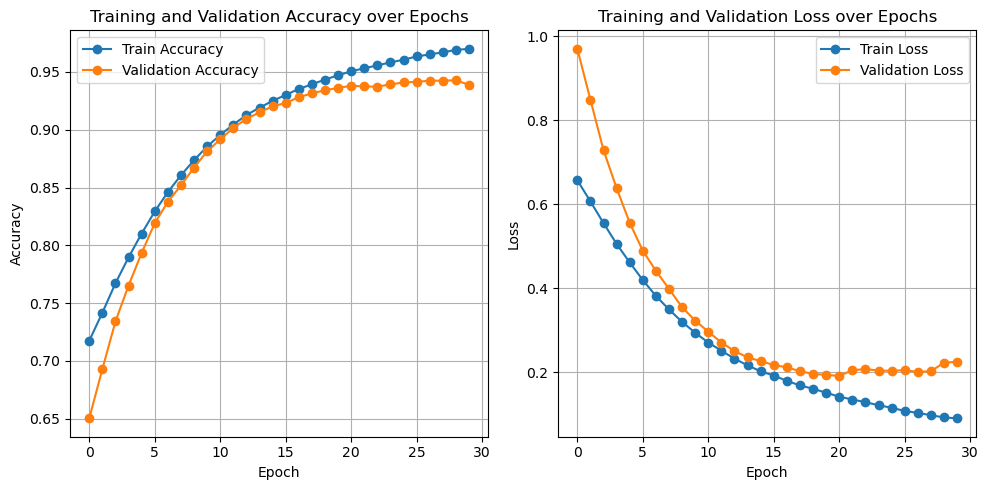

In [162]:
test_model_accuracy(model)

### Changing the Epsilon Value 0.5e-07

In [163]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=0.5e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_142 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_78 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_143 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_79 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_20 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [164]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 33ms/step - loss: 0.6732 - accuracy: 0.7182 - val_loss: 1.0517 - val_accuracy: 0.3896
Epoch 2/30
175/175 [==============================] - 5s 29ms/step - loss: 0.4069 - accuracy: 0.8510 - val_loss: 1.0562 - val_accuracy: 0.5390
Epoch 3/30
175/175 [==============================] - 6s 31ms/step - loss: 0.3392 - accuracy: 0.8718 - val_loss: 0.2762 - val_accuracy: 0.8799
Epoch 4/30
175/175 [==============================] - 5s 29ms/step - loss: 0.3061 - accuracy: 0.8845 - val_loss: 0.2492 - val_accuracy: 0.8999
Epoch 5/30
175/175 [==============================] - 5s 29ms/step - loss: 0.2667 - accuracy: 0.8970 - val_loss: 0.2189 - val_accuracy: 0.9146
Epoch 6/30
175/175 [==============================] - 6s 32ms/step - loss: 0.2547 - accuracy: 0.9063 - val_loss: 0.2059 - val_accuracy: 0.9235
Epoch 7/30
175/175 [==============================] - 5s 31ms/step - loss: 0.2306 - accuracy: 0.9132 - val_loss: 0.2175 - val_accuracy: 0.917

110/110 [==============================] - 1s 10ms/step - loss: 0.2674 - accuracy: 0.9308
Test Accuracy: 93.0798%


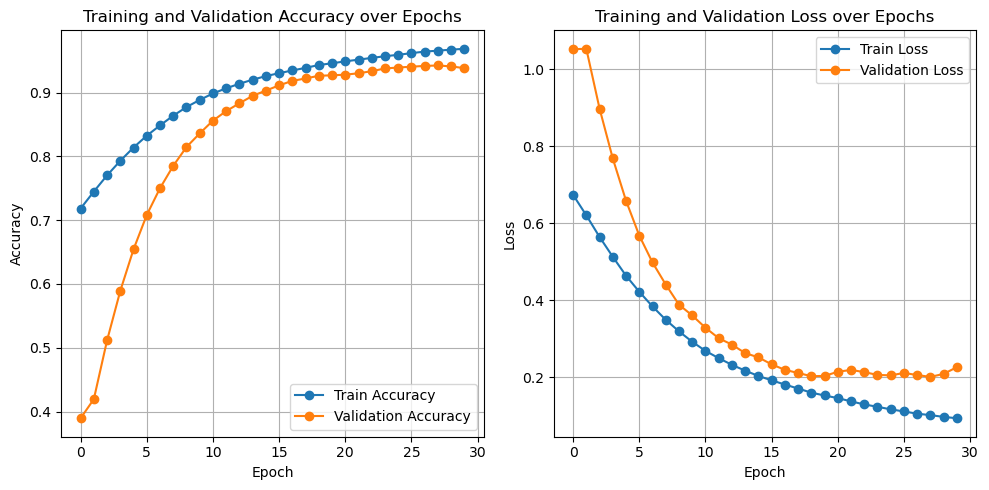

In [165]:
test_model_accuracy(model)

### Changing the Epsilon Value 0.75e-07

In [166]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=0.75e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_146 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_82 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_147 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_83 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_21 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [167]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 34ms/step - loss: 0.6106 - accuracy: 0.7350 - val_loss: 1.0102 - val_accuracy: 0.4421
Epoch 2/30
175/175 [==============================] - 5s 29ms/step - loss: 0.3992 - accuracy: 0.8323 - val_loss: 0.3713 - val_accuracy: 0.8631
Epoch 3/30
175/175 [==============================] - 5s 28ms/step - loss: 0.3429 - accuracy: 0.8678 - val_loss: 0.3119 - val_accuracy: 0.8670
Epoch 4/30
175/175 [==============================] - 5s 31ms/step - loss: 0.3013 - accuracy: 0.8825 - val_loss: 0.2407 - val_accuracy: 0.9021
Epoch 5/30
175/175 [==============================] - 5s 29ms/step - loss: 0.2718 - accuracy: 0.8920 - val_loss: 0.2559 - val_accuracy: 0.8981
Epoch 6/30
175/175 [==============================] - 5s 28ms/step - loss: 0.2563 - accuracy: 0.9016 - val_loss: 0.2261 - val_accuracy: 0.9078
Epoch 7/30
175/175 [==============================] - 5s 31ms/step - loss: 0.2309 - accuracy: 0.9117 - val_loss: 0.2041 - val_accuracy: 0.920

110/110 [==============================] - 1s 9ms/step - loss: 0.2163 - accuracy: 0.9457
Test Accuracy: 94.5668%


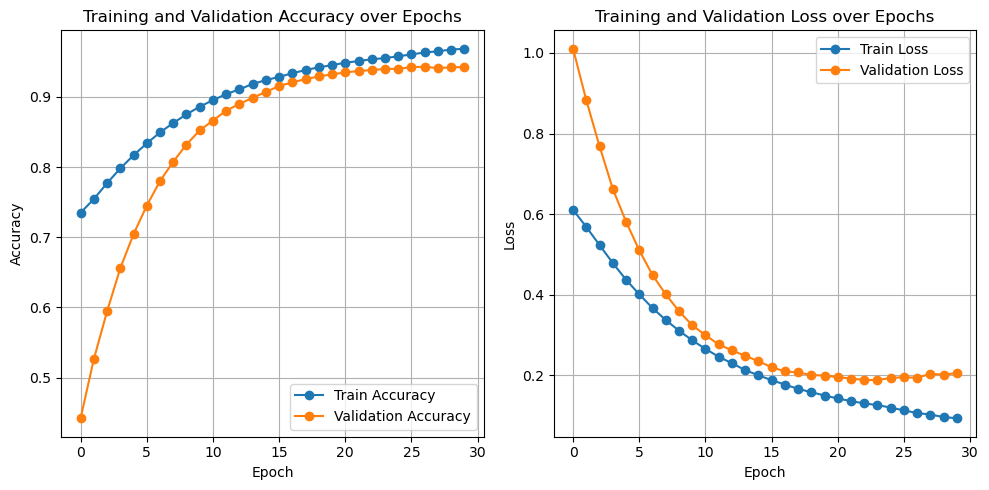

In [168]:
test_model_accuracy(model)

### Changing the Epsilon Value 1.2e-07

In [169]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=1.2e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_150 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_86 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_151 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_87 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_22 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [170]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 32ms/step - loss: 0.6385 - accuracy: 0.7270 - val_loss: 0.9156 - val_accuracy: 0.5897
Epoch 2/30
175/175 [==============================] - 5s 31ms/step - loss: 0.3833 - accuracy: 0.8494 - val_loss: 0.3561 - val_accuracy: 0.8628
Epoch 3/30
175/175 [==============================] - 5s 29ms/step - loss: 0.3355 - accuracy: 0.8673 - val_loss: 0.2584 - val_accuracy: 0.8906
Epoch 4/30
175/175 [==============================] - 5s 28ms/step - loss: 0.2947 - accuracy: 0.8849 - val_loss: 0.2548 - val_accuracy: 0.8996
Epoch 5/30
175/175 [==============================] - 5s 31ms/step - loss: 0.2730 - accuracy: 0.8942 - val_loss: 0.2548 - val_accuracy: 0.8964
Epoch 6/30
175/175 [==============================] - 5s 30ms/step - loss: 0.2522 - accuracy: 0.9041 - val_loss: 0.2415 - val_accuracy: 0.9042
Epoch 7/30
175/175 [==============================] - 5s 31ms/step - loss: 0.2286 - accuracy: 0.9139 - val_loss: 0.2471 - val_accuracy: 0.911

110/110 [==============================] - 1s 9ms/step - loss: 0.2163 - accuracy: 0.9460
Test Accuracy: 94.5954%


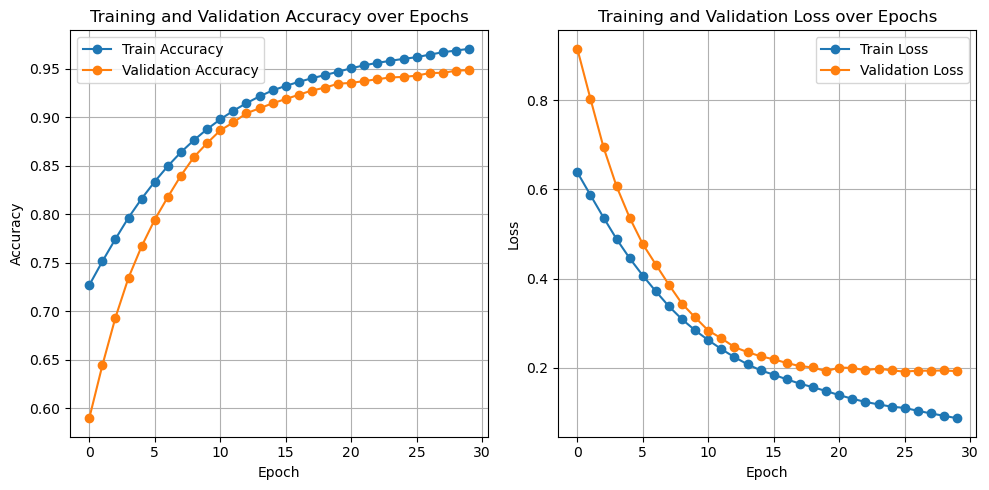

In [171]:
test_model_accuracy(model)

## Testing with SGD Optimizer

In [172]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = SGD(learning_rate=0.01)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_154 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_90 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_155 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_91 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_23 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [173]:
history = model.fit(x_train_gru, y_train_gru, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 11s 32ms/step - loss: 0.9443 - accuracy: 0.5169 - val_loss: 1.0850 - val_accuracy: 0.3906
Epoch 2/30
175/175 [==============================] - 5s 28ms/step - loss: 0.7668 - accuracy: 0.6552 - val_loss: 0.8926 - val_accuracy: 0.7241
Epoch 3/30
175/175 [==============================] - 5s 29ms/step - loss: 0.6769 - accuracy: 0.7214 - val_loss: 0.5922 - val_accuracy: 0.8063
Epoch 4/30
175/175 [==============================] - 5s 29ms/step - loss: 0.6032 - accuracy: 0.7624 - val_loss: 0.4863 - val_accuracy: 0.8295
Epoch 5/30
175/175 [==============================] - 5s 28ms/step - loss: 0.5532 - accuracy: 0.7920 - val_loss: 0.4357 - val_accuracy: 0.8399
Epoch 6/30
175/175 [==============================] - 5s 29ms/step - loss: 0.5070 - accuracy: 0.8057 - val_loss: 0.4030 - val_accuracy: 0.8485
Epoch 7/30
175/175 [==============================] - 5s 31ms/step - loss: 0.4837 - accuracy: 0.8148 - val_loss: 0.3835 - val_accuracy: 0.849

110/110 [==============================] - 1s 8ms/step - loss: 0.2773 - accuracy: 0.8933
Test Accuracy: 89.3337%


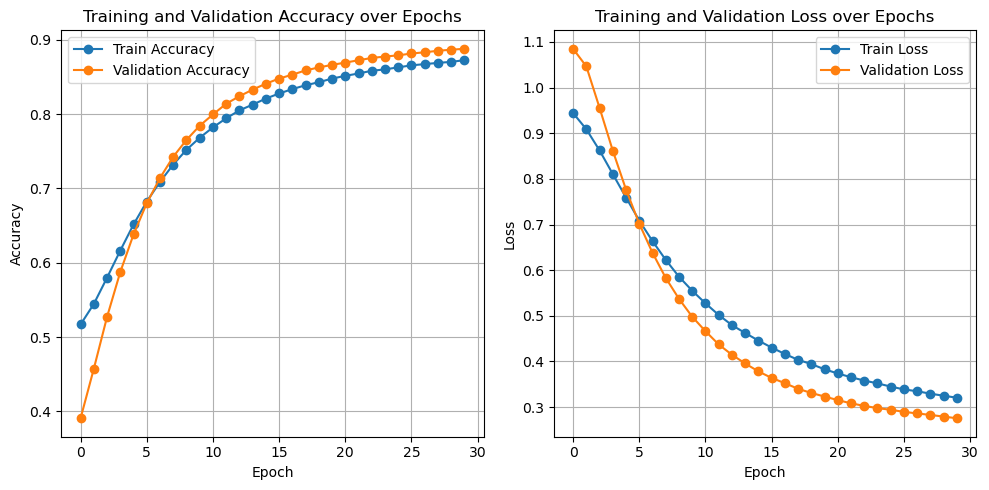

In [174]:
test_model_accuracy(model)

## Implementing Early Stopping

In [177]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input,LSTM,GRU,Flatten,BatchNormalization,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

time_steps=11
# Get the input shape
num_features = x_train_gru.shape[2]
num_classes = y_train_gru.shape[1]

# Create the GRU model
model = Sequential([
    GRU(128, input_shape=(time_steps, num_features),activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(128,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GRU(64,activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),

    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_162 (GRU)               (None, 11, 128)           73344     
                                                                 
 batch_normalization_98 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 gru_163 (GRU)               (None, 11, 128)           99072     
                                                                 
 batch_normalization_99 (Bat  (None, 11, 128)          512       
 chNormalization)                                                
                                                                 
 average_pooling1d_25 (Avera  (None, 5, 128)           0         
 gePooling1D)                                                    
                                                     

In [178]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  #Monitor validation loss
    patience=5,          #Number of epochs with no improvement after which training will be stopped
    min_delta=0.01,      #Minimum change to qualify as an improvement
    mode='min',          #The training will stop when the quantity monitored stops decreasing
    verbose=1            #Print messages when early stopping is triggered
)

# Testing with high number of epochs
history = model.fit(x_train_gru, y_train_gru, epochs=50, validation_split=0.2,batch_size=64, callbacks=[early_stopping])

Epoch 1/50
175/175 [==============================] - 11s 32ms/step - loss: 0.6448 - accuracy: 0.7251 - val_loss: 1.0127 - val_accuracy: 0.4021
Epoch 2/50
175/175 [==============================] - 5s 31ms/step - loss: 0.4224 - accuracy: 0.8398 - val_loss: 0.3598 - val_accuracy: 0.8821
Epoch 3/50
175/175 [==============================] - 5s 29ms/step - loss: 0.3618 - accuracy: 0.8602 - val_loss: 0.2658 - val_accuracy: 0.8910
Epoch 4/50
175/175 [==============================] - 5s 28ms/step - loss: 0.3066 - accuracy: 0.8791 - val_loss: 0.2735 - val_accuracy: 0.8903
Epoch 5/50
175/175 [==============================] - 5s 31ms/step - loss: 0.2857 - accuracy: 0.8896 - val_loss: 0.2164 - val_accuracy: 0.9103
Epoch 6/50
175/175 [==============================] - 6s 32ms/step - loss: 0.2520 - accuracy: 0.9042 - val_loss: 0.1865 - val_accuracy: 0.9253
Epoch 7/50
175/175 [==============================] - 5s 30ms/step - loss: 0.2241 - accuracy: 0.9156 - val_loss: 0.1983 - val_accuracy: 0.920

110/110 [==============================] - 1s 8ms/step - loss: 0.2188 - accuracy: 0.9257
Test Accuracy: 92.5651%


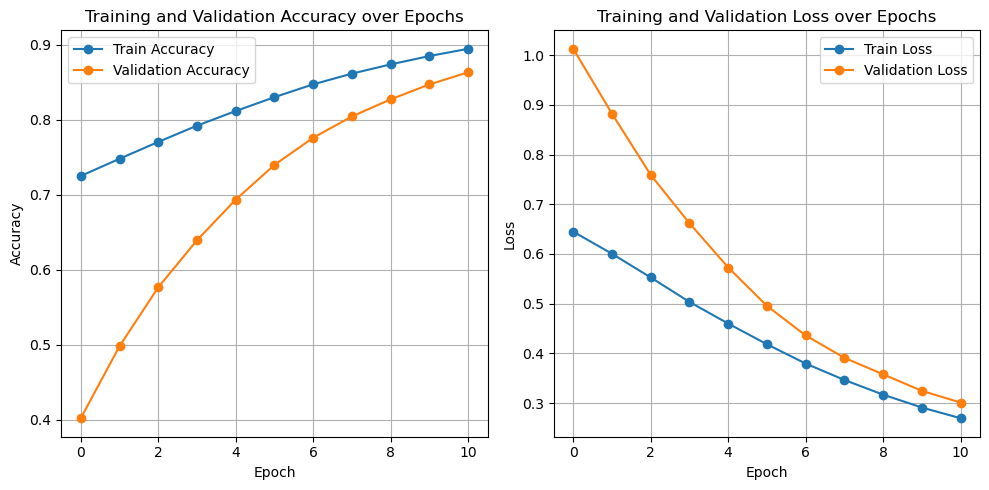

In [179]:
test_model_accuracy(model)